### Model Experiments and Final Solution Building
We've built a *baseline solution* and now we are going to conduct experiments with the model, for example:
- Define the best Imputer for both categorical and numeric features
- Define the best Encoder for categorical features and Scaler for numeric ones
- Define the best approach for dealing with class imbalance (setting weights, over/undersampling techniques...)
- Select the relevant set of features and look at their importance 
- Find model hyperparameters that provide the best quality

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.decomposition import PCA

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.target_encoder import TargetEncoder

from tqdm.notebook import tqdm as log_progress

warnings.filterwarnings('ignore')

In [2]:
# Helpful functions

def drop_nan_columns(df):
    feat_to_drop = [feature for feature in df.columns if df[feature].isna().all()]

    print(f'Dropped {len(feat_to_drop)} NaN Columns')
    df.drop(columns=feat_to_drop, axis=1, inplace=True)  
    
def plot_nan_ration(df, figsize=(10,5), title='Numerical Features'):
    fig = plt.figure(figsize=figsize)
    plt.hist(df.isna().sum()/df.shape[0])
    plt.xlabel('NaN Fraction')
    plt.ylabel('Number of Features')
    plt.title(title)
    plt.grid();    

In [3]:
# Set seed for reproducibility
SEED = 23

### Necessary Preprocessing
Some part of this taks we've already done in notebook: (`Churn_Project_Week_3-4_Baseline`)

In [5]:
# Download the training data
train_data = pd.read_csv('orange_small_churn_train_data.csv')
train_data

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [6]:
# Only one missing value for the target feature, drop it 
train_data.drop(index=18298, inplace=True)

# Rename the target
train_data.rename(columns={'labels':'is_churn'}, inplace=True)

# Drop ID column
train_data.drop('ID', axis=1, inplace=True)

# Split the features (numeric/categorical)
num_features = train_data.iloc[:, :190]
cat_features = train_data.iloc[:, 190:-1]

# Drop columns that consist of only NaN values   
drop_nan_columns(num_features)
drop_nan_columns(cat_features)

Dropped 16 NaN Columns
Dropped 2 NaN Columns


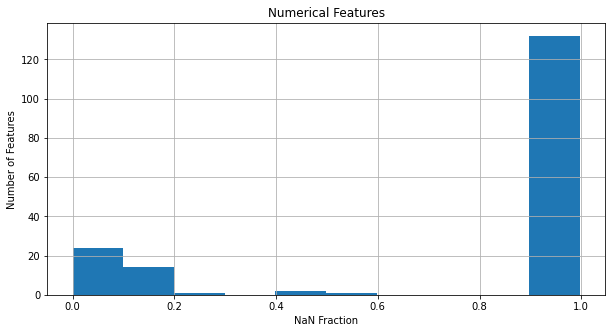

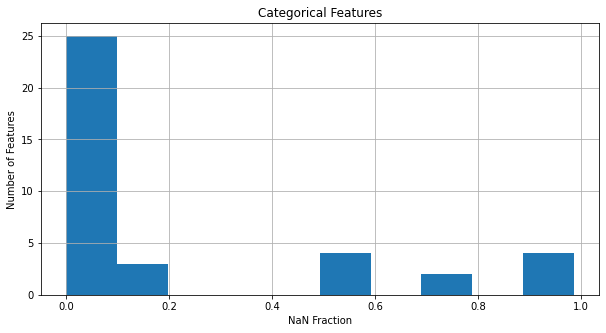

In [7]:
plot_nan_ration(num_features)
plot_nan_ration(cat_features, title='Categorical Features')

We've already seen these histograms. However, right now we will do the following:

**Numeric Features**

Features that have NaN ratio of more than 90% are eliminated. Features with NaN ration `40~60%` are included. If they are irrelevant, we will find it out on feature selection stage.

**Categorical Features**

Objects with NaN ratio of more than 90% are eliminated. The rest features are included and missing values are substituted by a new category `unknown`.

In [8]:
# Numeric Features (select by using the threshold 80%)
temp_frame = num_features.isna().sum()/num_features.shape[0]
columns = temp_frame[temp_frame < 0.8].index

num_features = num_features[columns]

# Categorical Features (select by using the threshold 80%)
temp_frame = cat_features.isna().sum()/cat_features.shape[0]
columns = temp_frame[temp_frame < 0.8].index

cat_features = cat_features[columns]

It's interesting to understand how many observations are needed for building a good-quality solution (i.e. have a look at how well the model is capable of the task). For this purpose, we use **learning curves**. We will be building a model on samples of different size and keep track of the model quality on cross-validation.

As before we are using `Pipeline` where we combine categorical and binary features in a single stage (`cat_bin_transformations`). This is because some binary features have missing values and after imputing they are no binary anymore, thus we combine these features.

For now, imputers, scalers and encoders have been chosen randomly.

In [9]:
# Define the function for Pipeline creation
def make_pipe(cat_bin_columns,
              num_columns,
              model=None,
              cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
              cat_bin_encoder=OneHotEncoder(sparse=True, handle_unknown='ignore'),
              num_imputer=SimpleImputer(strategy='mean'),
              num_scaler=StandardScaler()):
    
    # Categorical features processing
    cat_bin_pipeline = Pipeline([
        ('cat_bin_imputing', cat_bin_imputer),
        ('cat_bin_encoding', cat_bin_encoder),
        ('final_imputing', SimpleImputer(strategy='constant', fill_value=0)) # Полученные inf заменяем на 0
    ])
    
    # Numeric feature processing
    num_pipeline = Pipeline([
        ('num_imputing', num_imputer),
        ('num_scaling', num_scaler)
    ])
    
    # Main transformations 
    transformations = [
        ('cat_bin_transformations', cat_bin_pipeline, cat_bin_columns),
        ('num_transformations', num_pipeline, num_columns)
    ]
    
    feature_transformations = ColumnTransformer(transformers=transformations, n_jobs=-1)
    
    # Main Pipeline
    main_pipeline = Pipeline([
        ('feature_transformations', feature_transformations)
    ])
    
    if model is not None:
        main_pipeline.steps.insert(1, ('model', model))
        return main_pipeline
    else:
        return main_pipeline

In [11]:
# Define Pipeline
model_pipeline = make_pipe(cat_bin_columns=cat_features.columns,
                           num_columns=num_features.columns,
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=OneHotEncoder(sparse=True, handle_unknown='ignore'),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

In [10]:
# Train Data
x_train = pd.concat([num_features, cat_features], axis=1)
y_train = train_data['is_churn']

In [13]:
# Define the function for plotting the learning curves
def plot_with_std(n_samples, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(n_samples, mu, '-', **kwargs)
    plt.fill_between(n_samples, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(model, x_train, y_train, cv_type, scorer, train_data_split=20, shuffle=True, fit_params=None):
    train_sizes = np.linspace(0.05, 1, train_data_split)
    n_train, train_curve, val_curve = learning_curve(estimator=model, X=x_train, y=y_train,
                                                     cv=cv_type, scoring=scorer, train_sizes=train_sizes,
                                                     n_jobs=-1, shuffle=shuffle, random_state=SEED, fit_params=fit_params)
    plt.figure(figsize=(20,8))
    plot_with_std(n_train, train_curve, label='Training Scores')
    plot_with_std(n_train, val_curve, label='Validation Scores')
    plt.xlabel('Training Set Size')
    plt.ylabel(scorer)
    plt.legend()
    plt.grid()

Wall time: 3min 19s


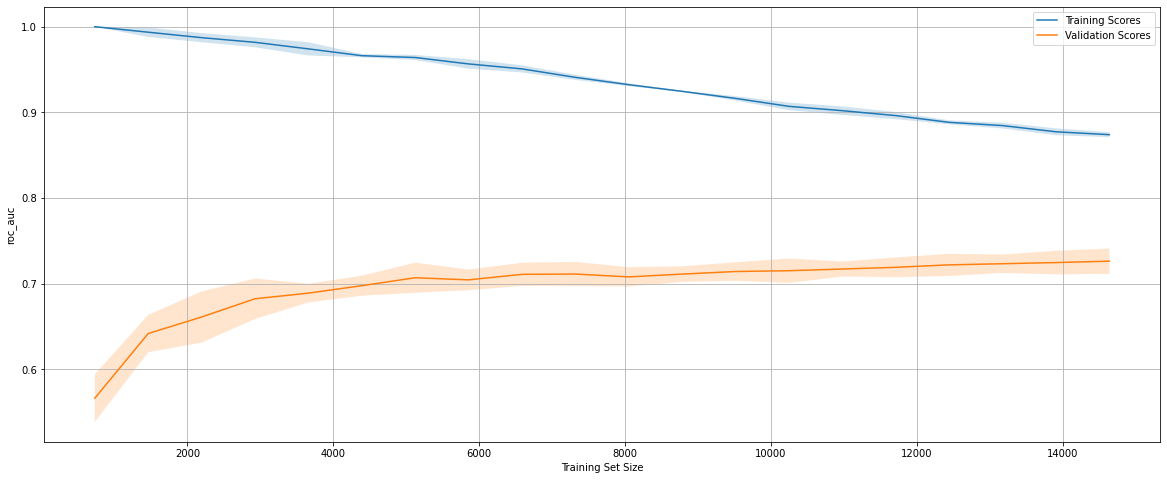

In [14]:
%%time

plot_learning_curve(model=model_pipeline,
                    x_train=x_train,
                    y_train=y_train, 
                    cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                    scorer='roc_auc')

In [15]:
%%time

# Model quality on cross-validation 
cv_results = cross_validate(model_pipeline, 
                            X=x_train, 
                            y=y_train,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED), 
                            scoring=['precision', 'recall', 'f1', 'roc_auc'], 
                            error_score='raise', 
                            n_jobs=-1)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 21.4 s


,test_precision,test_recall,test_f1,test_roc_auc
0,0.466667,0.007992,0.015704,0.726158


Learning curves shows us that we are dealing with  `High Variance Problem`. More data may lead to better quality. However, it's impossible in our case and the best way is to save the more data.

When we have `High Variance Problem` it means that the model is complicated and we overfit. There are the following solutions:
- Make the model simple
- Apply regularization and feature selection (the more features, the more complicated the model is)

### Feature Selection
First of all, we will apply thorough feature selection. When dealing with feature selection there are the following methods:
- *Filter Methods* (applying correlation analysis and statics)
- *Wrapper Method* (feature selection based on a model)
- *Embedded Methods* (Regularization: Lasso/Ridge)

### Feature Selection Using the Main Model
The main model in our `Pipeline` (`GradientBoostingClassifier`) has an access to feature importances. We can use this to define which features are important.

In [16]:
# Use TargetEncoder() to understand importances of features (not encoded)

# Redefine Pipeline
model_pipeline = make_pipe(cat_bin_columns=cat_features.columns,
                           num_columns=num_features.columns,
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

Wall time: 13.1 s


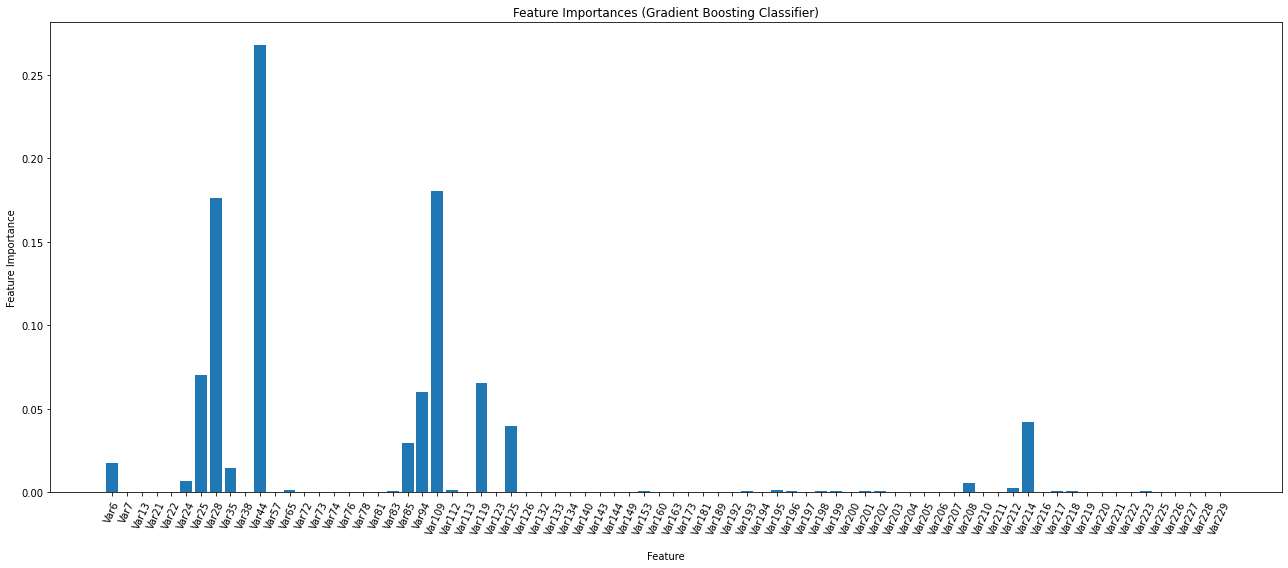

In [17]:
%%time

# Train the model and look at feature importances 
model_pipeline.fit(x_train, y_train)

plt.figure(figsize=(18,8))
plt.bar(x_train.columns, model_pipeline.steps[1][1].feature_importances_)
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosting Classifier)')
plt.xticks(rotation=65)
plt.tight_layout();

The main part of the features is unimportant for the model. This is a signal for feature selection.

Let's experiment on the current features. Select the features according to the threshold `feature_importances` using cross-validation

In [18]:
%%time

feat_importances = model_pipeline.steps[1][1].feature_importances_ # feature importances 
threshes = [0, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01] # thresh values for feature importances 
sel_feat_main_df = pd.DataFrame() # for saving the results 

# Iterate over thresh values
for thresh in threshes:
    current_columns = x_train.columns[feat_importances > thresh]
    X = x_train[current_columns].copy()
    
    # Redefine Pipeline on the current feature set
    model_pipeline = make_pipe(cat_bin_columns=X.select_dtypes('object').columns,
                               num_columns=X.select_dtypes(['float64', 'int64']).columns,
                               model=GradientBoostingClassifier(random_state=SEED),
                               cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                               cat_bin_encoder=TargetEncoder(),
                               num_imputer=SimpleImputer(strategy='mean'),
                               num_scaler=StandardScaler())
    # Cross-validate
    cv_results = cross_validate(model_pipeline,
                                X=X,
                                y=y_train,
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                error_score='raise',
                                n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
    cv_results['importance_thresh'] = thresh
    
    sel_feat_main_df = sel_feat_main_df.append(cv_results)
    
               
sel_feat_main_df = sel_feat_main_df.reset_index(drop=True)
sel_feat_main_df 

Wall time: 43 s


,test_precision,test_recall,test_f1,test_roc_auc,importance_thresh
0,0.418773,0.011613,0.022449,0.680323,0.00000
1,0.423571,0.011621,0.022524,0.682421,0.00001
2,0.368095,0.010891,0.021142,0.675918,0.00010
3,0.241667,0.004353,0.008536,0.625223,0.00100
4,0.000000,0.000000,0.000000,0.567931,0.01000
5,0.000000,0.000000,0.000000,0.543365,0.10000


The more feature we eliminate, the less the quality. It can be seen that thresh `1e-01` is the best, howevere it is still not enough. This approach is definitely not suitable as a feature selection.

### Wrapper Methods
let's define the relevant set of features using other models. We are going to use `RandomForest` to define top important features (a model will be built and feature importances obtained. Then their selection according to some threshold). Features that pass the selection stage are fitted by the main model. We also include `LogisticRegression` with Lasso regularization. Here we will use the module `SelectFromModel`

In [19]:
# Redefine Pipeline 
model_pipeline = make_pipe(cat_bin_columns=cat_features.columns,
                           num_columns=num_features.columns,
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=MinMaxScaler())

In [20]:
# Models Definition 
estimators = [
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=SEED),
    LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced',  n_jobs=-1, random_state=SEED),
    RidgeClassifier(class_weight='balanced', random_state=SEED)
]

In [21]:
%%time

# In order not to redefine the function we will be adding feature selection stage in the Pipeline using pipeline.steps.insert()

feat_sel_model_cv_res = pd.DataFrame()

for estimator in estimators:
    model_pipeline.steps.insert(1, ('feature_selection', SelectFromModel(estimator)))
    
    cv_results = cross_validate(model_pipeline, X=x_train, y=y_train,
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                error_score='raise',
                                n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T
    cv_results['selector_model'] = estimator
    
    feat_sel_model_cv_res = feat_sel_model_cv_res.append(cv_results)        
    model_pipeline.steps.pop(1)
    
             
feat_sel_model_cv_res = feat_sel_model_cv_res.reset_index(drop=True)
feat_sel_model_cv_res   

Wall time: 3min 21s


,test_precision,test_recall,test_f1,test_roc_auc,selector_model
0,0.467692,0.011626,0.022509,0.718814,RandomForestClassifier(class_weight='balanced'...
1,0.385824,0.018893,0.035798,0.730047,"LogisticRegression(class_weight='balanced', n_..."
2,0.434216,0.017426,0.033442,0.690203,"RidgeClassifier(class_weight='balanced', rando..."


`LogisticRegression` with Lasso regularization has demonstrated a really good result (`ROC-AUC: 0.73`) whereas `RandomForest` only `ROC-AUC: 0.71`

Let's have a look at what features were selected by `RandomForest` и `LogisticRegression`.

In [22]:
%%time

feat_importances = {} # model with feature importances 
estimators_sel_features = {} # features that passed the selection stage
final_model_feat_imp = np.array(1) # feature importances for the final model 

for estimator in estimators[:-1]:
    model_pipeline.steps.insert(1, ('feature_selection', SelectFromModel(estimator)))
    model_pipeline.fit(x_train, y_train)
    
    estimator_name = str(estimator).split('(')[0]
    
    if estimator_name == 'RandomForestClassifier':
        feat_importances[estimator_name] = model_pipeline.steps[1][1].estimator_.feature_importances_
        estimators_sel_features[estimator_name] = model_pipeline.steps[1][1].get_support()
        print(f'Feature Selection Threshold ({estimator_name}): ', model_pipeline.steps[1][1].threshold_)
    else:
        feat_importances[estimator_name] = model_pipeline.steps[1][1].estimator_.coef_
        final_model_feat_imp = model_pipeline.steps[2][1].feature_importances_
        estimators_sel_features[estimator_name] = model_pipeline.steps[1][1].get_support()
        print(f'Feature Selection Threshold ({estimator_name}): ', model_pipeline.steps[1][1].threshold_)
        
    model_pipeline.steps.pop(1)

Feature Selection Threshold (RandomForestClassifier):  0.013157894736842105
Feature Selection Threshold (LogisticRegression):  1e-05
Wall time: 1min 37s


`Feature Selection Threshold` has been printed to understand what thresh value was used to select the features.

In [23]:
# Let's create a DataFrame with the results 
feat_importances['LogisticRegression'] = feat_importances['LogisticRegression'][0] # Instead 2d, make 1d array
feat_imp_models_df = pd.DataFrame(feat_importances, index=x_train.columns)
feat_imp_models_df

,RandomForestClassifier,LogisticRegression
Var6,0.022251,4.644838
Var7,0.002881,1.885422
Var13,0.000623,0.000000
Var21,0.001262,-1.397746
Var22,0.000313,0.000000
...,...,...
Var225,0.005068,-0.459554
Var226,0.004960,0.540339
Var227,0.000401,0.373274
Var228,0.000984,-0.612635


In [24]:
# Sort the features according to their importance (For LASSo use absolute importance)
lasso_sorted_df = feat_imp_models_df['LogisticRegression'].abs().sort_values(ascending=False)
rm_forest_sorted_df = feat_imp_models_df['RandomForestClassifier'].sort_values(ascending=False)

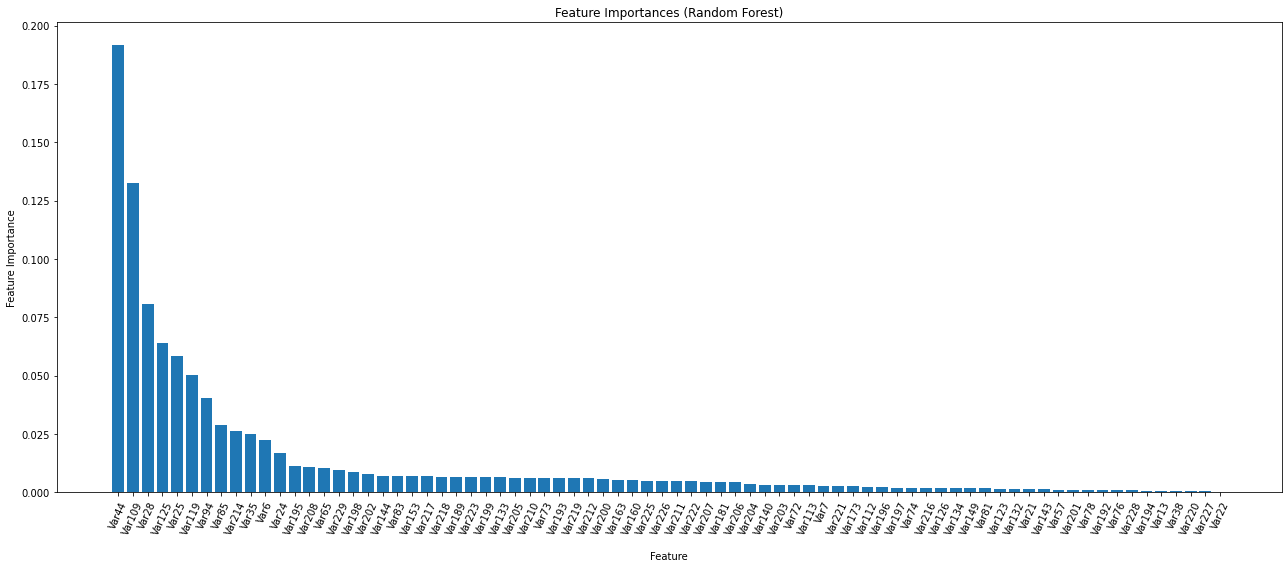

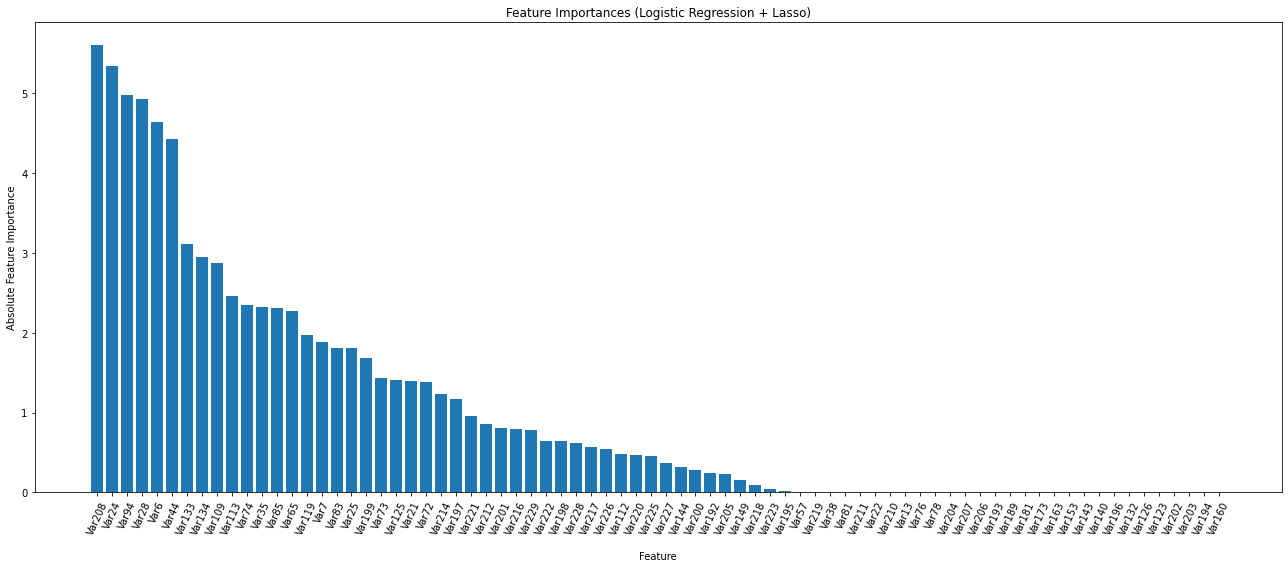

In [25]:
# Feature Importances (Random Forest)
plt.figure(figsize=(18,8))
plt.bar(rm_forest_sorted_df.index, rm_forest_sorted_df)
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.xticks(rotation=65)
plt.tight_layout();

# Feature Importances (Logistic Regression)
plt.figure(figsize=(18,8))
plt.bar(lasso_sorted_df.index, lasso_sorted_df)
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Absolute Feature Importance')
plt.title('Feature Importances (Logistic Regression + Lasso)')
plt.xticks(rotation=65)
plt.tight_layout();

For now, we can see that there is a set of features that are uninformative and irrelevant. I'd like to point out `Logistic Regression` with Lasso that allows to figure out what features are noise. 

Besides, let's have a look at feature importances for the main model (`Gradient Boosting Classifier`)

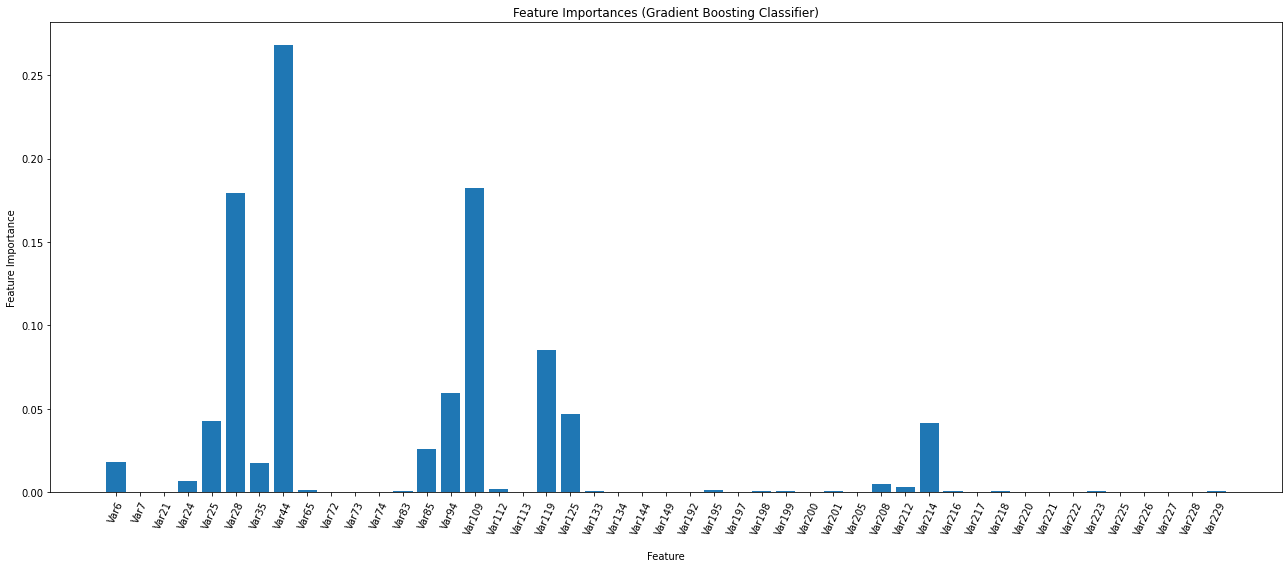

In [26]:
plt.figure(figsize=(18,8))
plt.bar(x_train.iloc[:, estimators_sel_features['LogisticRegression']].columns, final_model_feat_imp)
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosting Classifier)')
plt.xticks(rotation=65)
plt.tight_layout();

Even after Lasso selection, there are features that are still unimportant for the main model. Let's carry on the feature selection part and use one more method.

### Filter Methods 
Here we apply the following methods based on correlation:
- Categorical Features: Crammer's V
- Numeric Features: Chi-Squared

### Numeric Values 
Use the chi-squared method. This method requires that features have to be scaled and don't have any missing values.

In [27]:
# Feature processing
num_feat_testing = SimpleImputer(strategy='mean').fit_transform(num_features)
num_feat_testing = MinMaxScaler().fit_transform(num_feat_testing)

In [28]:
# Calcualte Chi-Squared Value 
feat_selector = SelectKBest(score_func=chi2, k=5)
feat_selector.fit(num_feat_testing, y_train)

num_feat_chi_2_df = pd.DataFrame({'chi_2_score': feat_selector.scores_,
                                  'p_value': feat_selector.pvalues_}, index=num_features.columns)

num_feat_chi_2_df = num_feat_chi_2_df.sort_values(['chi_2_score'] , ascending=False)
num_feat_chi_2_df

,chi_2_score,p_value
Var73,16.038488,0.000062
Var7,12.069929,0.000512
Var144,6.781379,0.009211
Var65,4.532769,0.033252
Var143,3.159712,0.075477
Var126,2.787415,0.095007
Var189,2.774681,0.095766
Var72,2.344515,0.125725
Var13,2.300745,0.129312
Var173,1.711702,0.190765


Since we don't have many numeric features, we will iterate over features in `num_feat_chi_2_df` from top `chi_2_score` till the end. Each iteration a new feature is being added and the model is being fitted on `n+1` set of features.

In [29]:
%%time

current_feat_set = []
chi_2_cv_res = pd.DataFrame()

model_pipeline = Pipeline([
    ('num_imputing', SimpleImputer(strategy='mean')),
    ('num_scaling', MinMaxScaler()),
    ('model', GradientBoostingClassifier(random_state=SEED))
])


for feature in log_progress(num_feat_chi_2_df.index):
    current_feat_set.append(feature)
    
    cv_results = cross_validate(model_pipeline,
                                X=num_features.loc[:, current_feat_set],
                                y=y_train,
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                error_score='raise',
                                n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T
    chi_2_cv_res = chi_2_cv_res.append(cv_results)
     
chi_2_cv_res.index = num_feat_chi_2_df.index


Wall time: 3min 45s


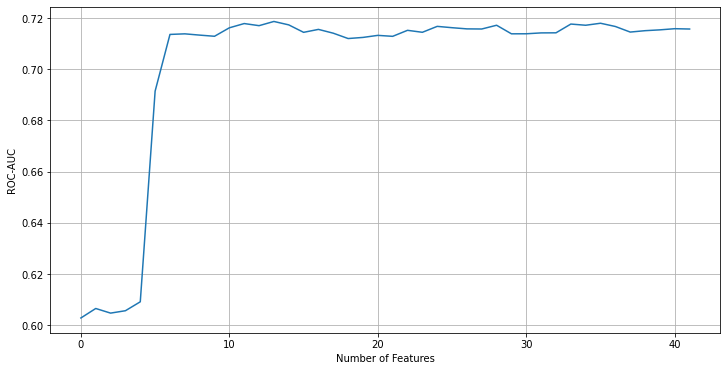

In [30]:
# ROC-AUC changing 
plt.figure(figsize=(12,6))
plt.plot(np.arange(chi_2_cv_res.index.shape[0]), chi_2_cv_res['test_roc_auc'])
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.grid();

**The first 15 features** lead to quality improvement then it stops. Based on this, select the first 15 features and the rest eliminate.

In [31]:
# Select only important features 
last_signif_num_feature = chi_2_cv_res[chi_2_cv_res['test_roc_auc'] == chi_2_cv_res['test_roc_auc'].max()].index[0]
las_sign_num_feat_indx = chi_2_cv_res.index.get_loc(last_signif_num_feature)

selected_num_features = chi_2_cv_res.index[:las_sign_num_feat_indx+1]

# Define a new set of numeric features (selected)
num_features_selected = num_features[selected_num_features]

### Categorical Features
For selecting categorical features we are going to use `Crammer's V`

In [32]:
# Define the function for V-Crammer calculation
def calculate_crammer_coef(feature_df, target, correction=True, return_p_value=True, ascending=False):

    crammer_corrs = [] 
    
    for feature in feature_df.columns:
        confusion_matrix = pd.crosstab(feature_df[feature], target)
        n_observations = feature_df[feature].shape[0]
        n_rows, n_colmns = confusion_matrix.shape
    
        ratio = (np.sum((confusion_matrix.loc[:, -1] < 5)) + np.sum((confusion_matrix.loc[:, -1] < 5)))/confusion_matrix.size
        
        if ratio <= 0.2:
            # p-values option
            if return_p_value:
                chi2_res = sts.chi2_contingency(confusion_matrix, correction=correction)
                crammer_corrs.append((feature_df[feature].name, chi2_res[1], np.sqrt(chi2_res[0]/(n_observations*(min(n_rows, n_colmns)-1)))))
            else:
                chi2_val = sts.chi2_contingency(confusion_matrix, correction=correction)[0]
                crammer_corrs.append((feature_df[feature].name, np.sqrt(chi2_val/(n_observations*(min(n_rows, n_colmns)-1)))))
    
    return pd.DataFrame(crammer_corrs, columns=['Feature', 'p-value', 'V_Crammer_Value']).sort_values(by='V_Crammer_Value', ascending=ascending)

In [33]:
# Calculate correlations
cat_feat_corrs = calculate_crammer_coef(feature_df=cat_features,
                                        target=y_train,
                                        return_p_value=True,
                                        ascending=False)
cat_feat_corrs

,Feature,p-value,V_Crammer_Value
2,Var204,6.432376e-03,0.086667
4,Var206,4.692453e-15,0.078724
3,Var205,2.479449e-25,0.078693
5,Var207,3.113104e-12,0.065424
7,Var210,9.418743e-13,0.059768
14,Var227,1.817751e-10,0.055818
13,Var226,6.353453e-03,0.047876
10,Var221,8.783147e-07,0.045898
9,Var218,1.172975e-08,0.042165
8,Var211,5.526661e-05,0.029808


Conduct the same experiment as we've done before with numeric ones

In [34]:
%%time

v_crammer_cv_df = pd.DataFrame()
current_feat_set = []

model_pipeline = Pipeline([
    ('cat_imputing', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('cat_encoder', TargetEncoder()),
    ('model', GradientBoostingClassifier(random_state=SEED))
])

for feature in log_progress(cat_feat_corrs['Feature'].values):
    current_feat_set.append(feature)
    
    cv_results = cross_validate(model_pipeline,
                                X=cat_features.loc[:, current_feat_set],
                                y=y_train,
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                error_score='raise',
                                n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
    v_crammer_cv_df = v_crammer_cv_df.append(cv_results)
     
v_crammer_cv_df.index = cat_feat_corrs['Feature'].values


Wall time: 27.7 s


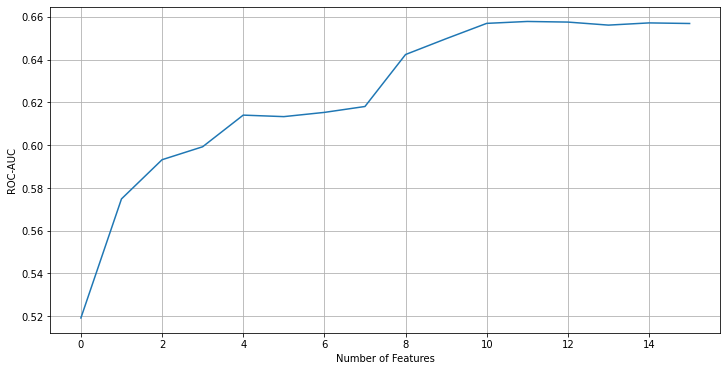

In [35]:
# ROC-AUC changing 
plt.figure(figsize=(12,6))
plt.plot(np.arange(v_crammer_cv_df.index.shape[0]), v_crammer_cv_df['test_roc_auc'])
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.grid();

Select only those features that provide quality improvement

In [36]:
# Select only important features  
last_signif_cat_feature = v_crammer_cv_df[v_crammer_cv_df['test_roc_auc'] == v_crammer_cv_df['test_roc_auc'].max()].index[0]
last_sign_cat_feat_indx = v_crammer_cv_df.index.get_loc(last_signif_cat_feature)

selected_cat_features = v_crammer_cv_df.index[:last_sign_cat_feat_indx+1]

# Define a new set of categorical features (selected)
cat_features_selected = cat_features[selected_cat_features]

We've done a lot of work with the feature selection part. Let's have a look at how the main quality has changed. 

In [37]:
x_train = pd.concat([num_features_selected, cat_features_selected], axis=1)

model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes(['object']).columns.to_list(),
                           num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=MinMaxScaler())

In [38]:
%%time

cv_results = cross_validate(model_pipeline,
                            X=x_train,
                            y=y_train,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED),
                            scoring=['precision', 'recall', 'f1', 'roc_auc'],
                            error_score='raise',
                            n_jobs=-1)

cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
cv_results

Wall time: 4.72 s


,test_precision,test_recall,test_f1,test_roc_auc
0,0.458068,0.021787,0.041306,0.733065


It has improved the score! In the next experiments, we will be using only selected features.

### Outliers and Features with Low Variance
Among numeric features there are outliers, let's have a look at `BoxPlot`

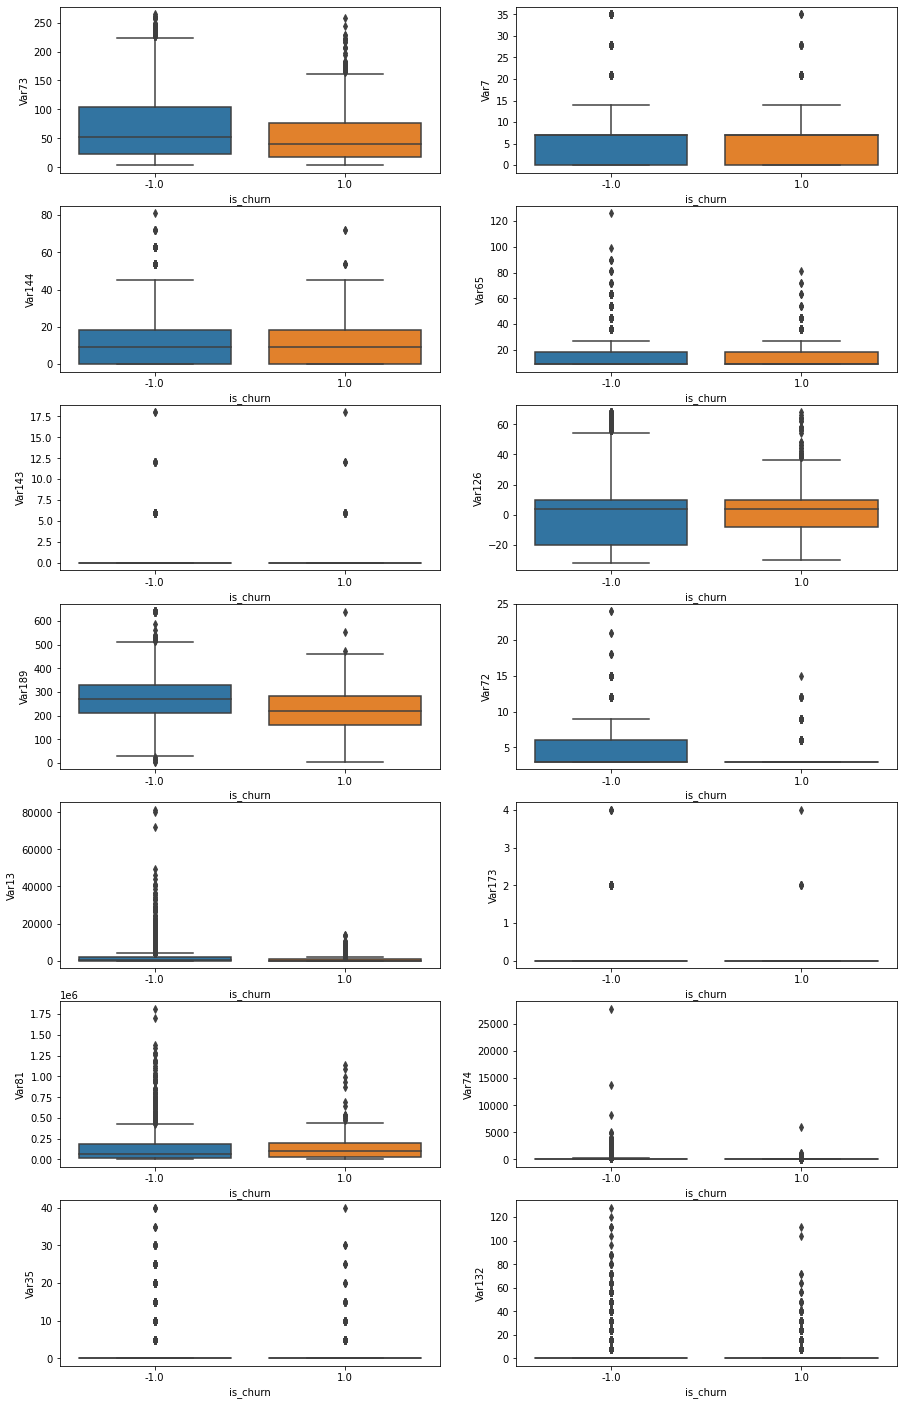

In [39]:
fig, axes = plt.subplots(7, 2, figsize=(15, 25))
for indx, feature in enumerate(num_features_selected.columns):
    sns.boxplot(x=y_train, y=num_features_selected[feature], ax=axes[indx // 2, indx % 2])

It can be observed that there are features that don't change/vary much. Perhaps, we should eliminate them as well. `BoxPlot` shows that features `Var143 Var173 Var35 Var132` have low dispersion. Let's exclude them and look at the quality.

In [40]:
# Numeric features statistics
num_features_selected.describe()

,Var73,Var7,Var144,Var65,Var143,Var126,Var189,Var72,Var13,Var173,Var81,Var74,Var35,Var132
count,18298.000000,16322.000000,16307.000000,16322.000000,16506.000000,13255.000000,7681.000000,10136.000000,16322.000000,16506.000000,1.630700e+04,16322.000000,16506.000000,16506.000000
mean,66.711881,6.791141,11.749617,14.891190,0.063613,-0.550283,269.753157,4.206689,1245.570151,0.006543,1.031159e+05,102.637361,0.723676,3.508542
std,52.890539,6.283886,11.806254,10.090197,0.694515,22.350187,86.739021,2.323429,2707.566854,0.124369,1.054671e+05,359.042672,2.917431,9.751289
min,4.000000,0.000000,0.000000,9.000000,0.000000,-32.000000,6.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,9.000000,0.000000,-20.000000,204.000000,3.000000,0.000000,0.000000,1.632852e+04,0.000000,0.000000,0.000000
50%,52.000000,7.000000,9.000000,9.000000,0.000000,4.000000,270.000000,3.000000,236.000000,0.000000,7.350330e+04,7.000000,0.000000,0.000000
75%,102.000000,7.000000,18.000000,18.000000,0.000000,10.000000,324.000000,6.000000,1608.000000,0.000000,1.826675e+05,91.000000,0.000000,0.000000
max,264.000000,35.000000,81.000000,126.000000,18.000000,68.000000,642.000000,24.000000,81268.000000,4.000000,1.814400e+06,27783.000000,40.000000,128.000000


I was experimenting with other features as well and it turned out that `Var72` **must be excluded as well** (it increases the quality)

In [41]:
# Exclude features
columns_to_drop = ['Var143', 'Var173', 'Var132', 'Var35', 'Var72']
x_train_sel = x_train[x_train.columns.difference(x_train[columns_to_drop].columns)]

num_features_selected = x_train_sel.select_dtypes(['int64', 'float64'])
cat_features_selected = x_train_sel.select_dtypes('object')

In [42]:
%%time

model_pipeline = make_pipe(cat_bin_columns=x_train_sel.select_dtypes(['object']).columns.to_list(),
                           num_columns=x_train_sel.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

cv_results = cross_validate(model_pipeline, X=x_train_sel, y=y_train,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED),
                            scoring=['precision', 'recall', 'f1', 'roc_auc'],
                            error_score='raise',
                            n_jobs=-1)
    
cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T
cv_results

Wall time: 4.52 s


,test_precision,test_recall,test_f1,test_roc_auc
0,0.478095,0.022516,0.042829,0.734913


The score has improved a bit again and now we have features with a good dispersion. However, we still have outliers. Let's find these observations and change them into NaN values, then apply imputation (I've applied outliers removal and it only decreased the score `ROC-AUC: 0.68`)

In [43]:
# Define the function for outliers removal 
def remove_outliers(df_in, col = '', strategy='fill_na'):
    """
    Calculates quantiles for outliers + interquartile range. Everything above and below the borders will not be included
    in final dataframe.
    
    """
    Q1 = df_in[col].quantile(0.25)
    Q3= df_in[col].quantile(0.75)
    IRQ = Q3 - Q1
    upper_border = Q3 + IRQ*1.5
    lower_border = Q1 - IRQ*1.5
    
    if strategy == 'fill_na':
        mask = (df_in[col] >= lower_border) & (df_in[col] <= upper_border)
        df_in[col] = df_in[col].where(mask)
        
        return df_in[col]

# Select outliers and substitute them into NaN
res_df = pd.DataFrame()

for feature in num_features_selected.columns:
    current_df = remove_outliers(num_features_selected, col=feature)
    res_df = pd.concat([res_df, current_df], axis=1)

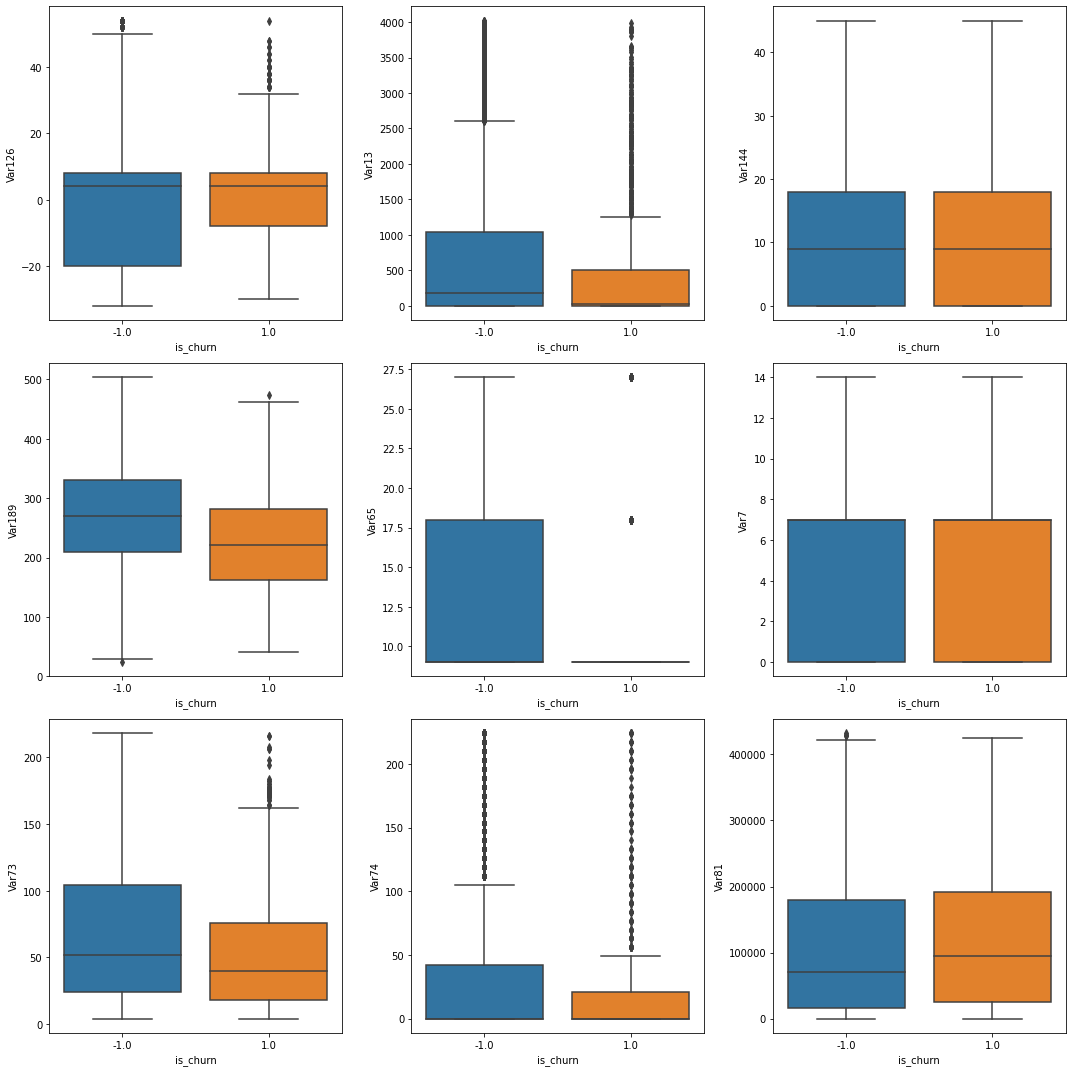

In [44]:
# let's have a look at how the BoxPlot has changed 
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for indx, feature in enumerate(res_df.columns):
    sns.boxplot(x=y_train, y=res_df[feature], ax=axes[indx // 3, indx % 3])
plt.tight_layout()

This allowed to decrease the number of outliers

In [45]:
%%time

# New training data
x_train_testing = pd.concat([res_df, cat_features_selected], axis=1)

model_pipeline = make_pipe(cat_bin_columns=x_train_testing.select_dtypes(['object']).columns.to_list(),
                           num_columns=x_train_testing.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

cv_results = cross_validate(model_pipeline, X=x_train_testing, y=y_train,
                            cv=StratifiedKFold(shuffle=True, random_state=SEED),
                            scoring=['precision', 'recall', 'f1', 'roc_auc'],
                            error_score='raise',
                            n_jobs=-1)
    
cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T
cv_results

Wall time: 4.26 s


,test_precision,test_recall,test_f1,test_roc_auc
0,0.505371,0.021067,0.040234,0.733274


The score has dropped down, though not much. Besides, it is a good idea to **look at the objects in the future space** because it helps to answer the following questions:
- How do they overlap?
- How well is it possible to separate them?

For this purpose, we use `PCA` and downside multidimensional data in 2D. For using `PCA` we need:
- Get rid of missing values 
- Encode categorical features
- Scale numeric features

In [12]:
# Define a function that allow plotting multidimensional data
def plot_multidim_data(x_train,
                       y_train, 
                       cat_bin_imputer=SimpleImputer(strategy='most_frequent'),
                       cat_bin_encoder=CatBoostEncoder(random_state=SEED),
                       num_imputer=SimpleImputer(strategy='mean'),
                       num_scaler=StandardScaler(),
                       dim_red_method=PCA(n_components=2),
                       sampling_method=None,
                       fig_size=(12,6),
                       title='2D Feature Space (PCA)'):

    
    # Feature Selection
    num_features = x_train.select_dtypes(include=['float64', 'int64'])
    cat_bin_features = x_train.select_dtypes(include=['object'])
    
    # Categorical Feature Processing
    cat_bin_features = cat_bin_imputer.fit_transform(cat_bin_features)
    cat_bin_features = cat_bin_encoder.fit_transform(cat_bin_features, y_train)
    
    # Numeric Feature Processing 
    num_features = num_imputer.fit_transform(num_features)
    num_features = num_scaler.fit_transform(num_features)

    # Final Matrix of features 
    final_matrix = np.hstack((num_features, cat_bin_features))
    
    target_name = y_train.name
    
    # If we use under/oversampling method 
    if sampling_method:
        final_matrix, y_train = sampling_method.fit_resample(final_matrix, y_train.values)
        
    final_matrix_2d = pd.DataFrame(dim_red_method.fit_transform(final_matrix))
    final_matrix_2d[target_name] = y_train
    
    print('Number of Samples (Negative Class): ', final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train).min()].shape[0])
    print('Number of Samples (Positive Class): ', final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train).max()].shape[0])
    
    # Plotting 
    plt.figure(figsize=fig_size)
    plt.scatter(final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train)[0]][0], 
                final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train)[0]][1],
                label=np.unique(y_train)[0])
    
    plt.scatter(final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train)[1]][0], 
                final_matrix_2d[final_matrix_2d[target_name] == np.unique(y_train)[1]][1],
                label=np.unique(y_train)[1])
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.title(title)
    plt.grid()
    plt.legend()

Have a look at the objects in the future space **with and without outliers.**

Number of Samples (Negative Class):  16921
Number of Samples (Positive Class):  1377
Wall time: 388 ms


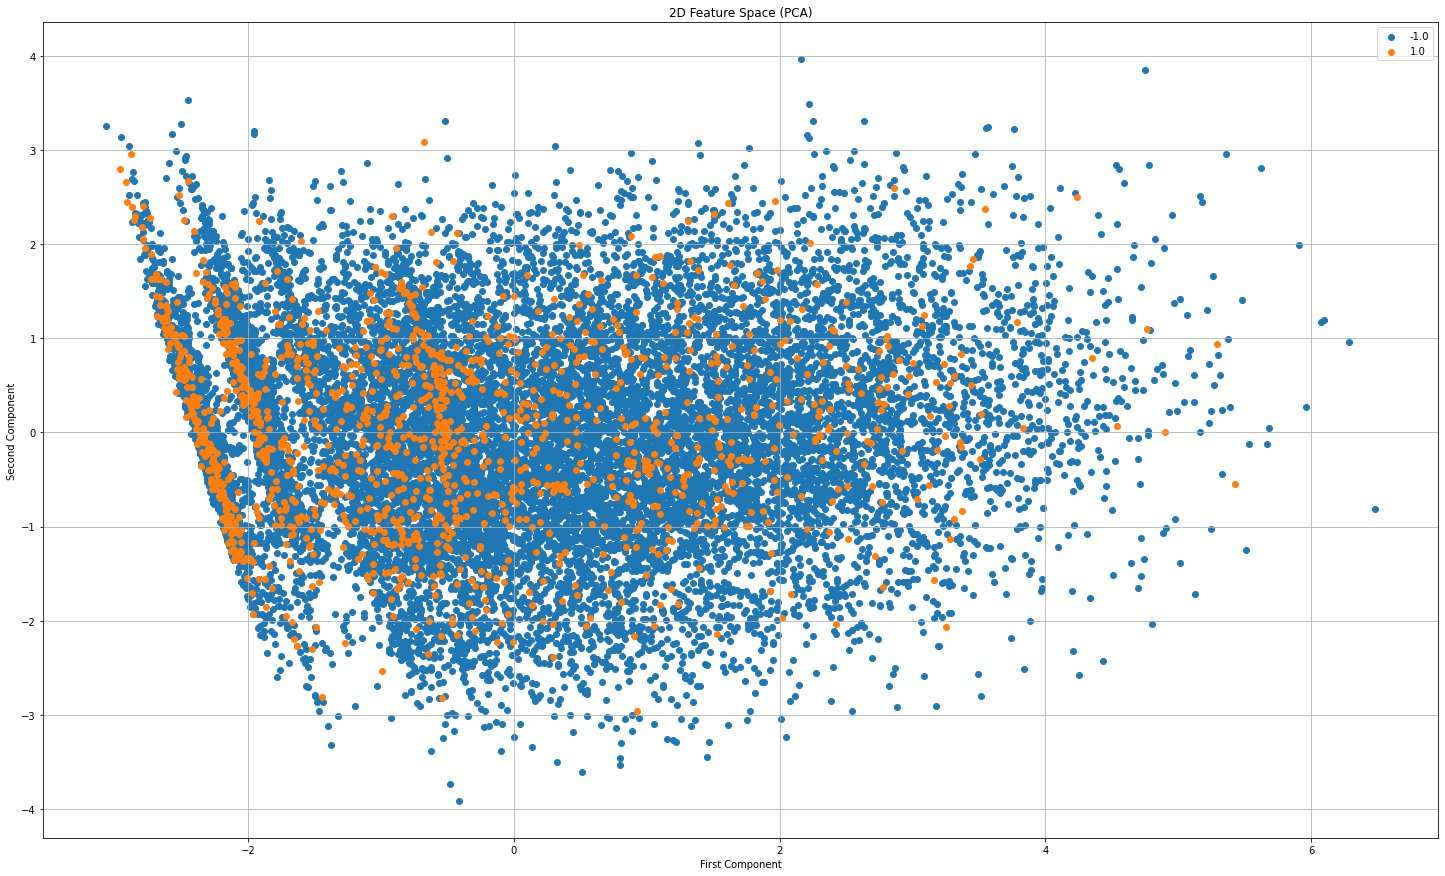

In [64]:
%%time

# Without outliers 
plot_multidim_data(x_train=x_train_testing,
                   y_train=y_train, 
                   cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                   cat_bin_encoder=TargetEncoder(),
                   num_imputer=SimpleImputer(strategy='mean'),
                   num_scaler=StandardScaler(),
                   dim_red_method=PCA(n_components=2, random_state=SEED),
                   fig_size=(25,15), 
                   title='2D Feature Space (PCA)')

Number of Samples (Negative Class):  16921
Number of Samples (Positive Class):  1377
Wall time: 303 ms


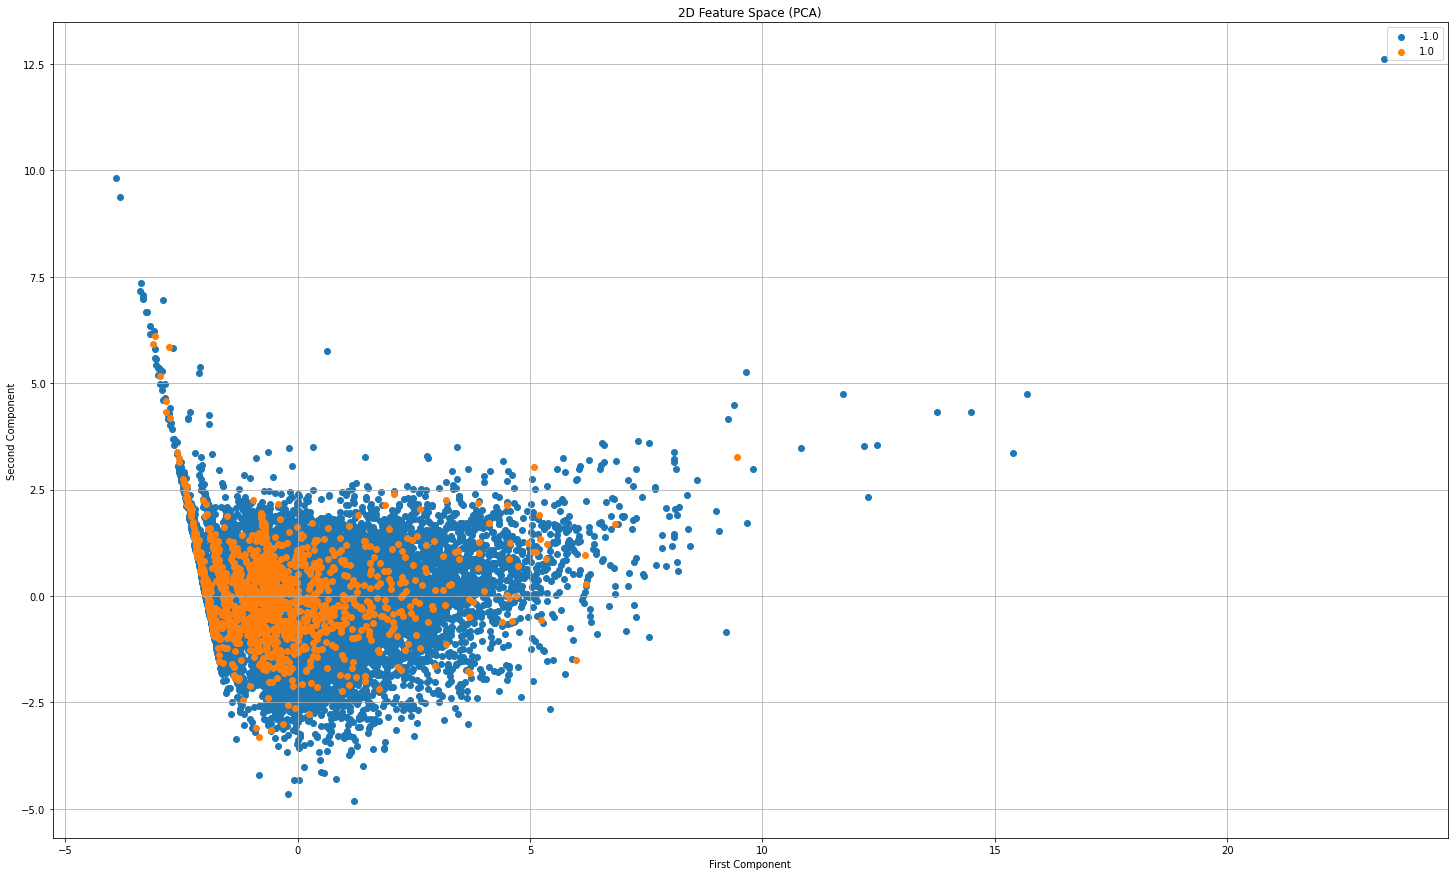

In [65]:
%%time

# With outliers 
plot_multidim_data(x_train=x_train_sel,
                   y_train=y_train, 
                   cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                   cat_bin_encoder=TargetEncoder(),
                   num_imputer=SimpleImputer(strategy='mean'),
                   num_scaler=StandardScaler(),
                   dim_red_method=PCA(n_components=2, random_state=SEED),
                   fig_size=(25,15), 
                   title='2D Feature Space (PCA)')

It can be seen that without outliers, the observations are not so densely concentrated in comparison with outliers. However, in my opinion, it is better to leave the option with outliers for now. **Perhaps they contain some useful information, and we have a slightly higher quality**.

In [48]:
# look at categorical features
cat_features_selected = x_train.select_dtypes('object')
cat_features_selected.describe()

,Var204,Var206,Var205,Var207,Var210,Var227,Var226,Var221,Var218,Var211,Var225,Var203
count,18298,16307,17584,18298,18298,18298,18298,18298,18029,18298,8727,18243
unique,100,21,3,12,6,7,23,7,2,2,3,3
top,RVjC,IYzP,VpdQ,me75fM6ugJ,uKAI,RAYp,FSa2,oslk,cJvF,L84s,ELof,9_Y1
freq,643,6324,11665,12835,17412,12864,2924,13530,9270,14730,4088,16585


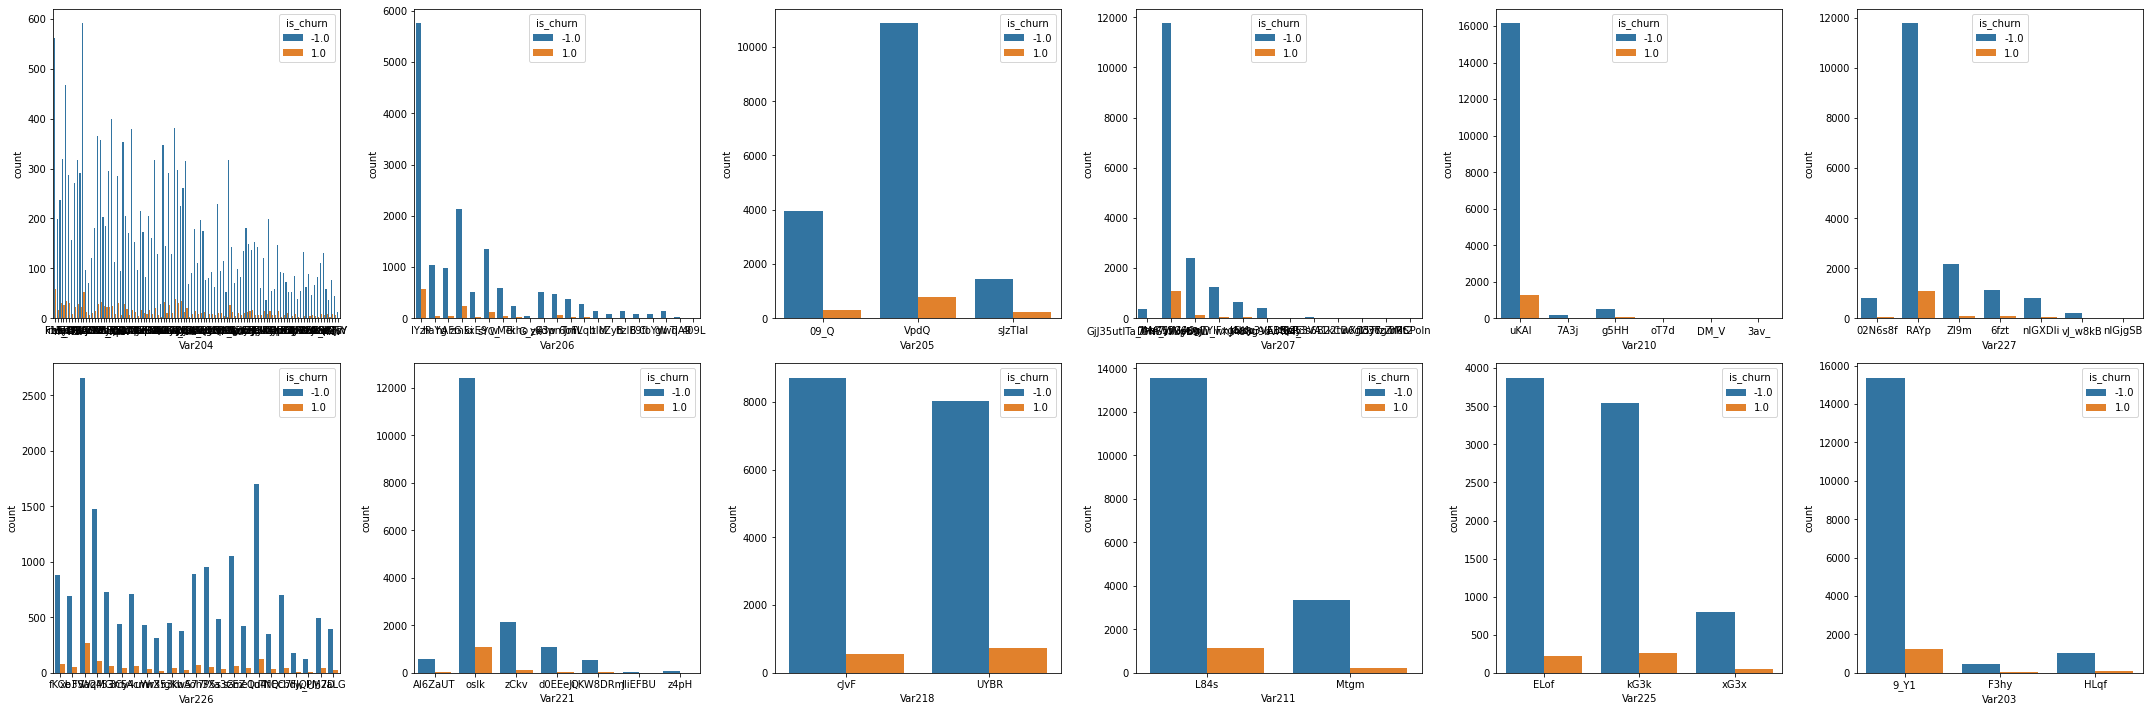

In [49]:
temp_df = cat_features_selected.copy()
temp_df['is_churn'] = y_train

fig, axes = plt.subplots(2, 6, figsize=(30, 10))
for indx, feature in enumerate(temp_df.columns[:-1]):
    sns.countplot(data=temp_df, x=feature, hue='is_churn', ax=axes[indx // 6, indx % 6])
plt.tight_layout()

Categorical features have rare categories and it's bad for the model as well. As a solution, rare categories can be grouped into 
a new one `other`. We leave this option as a way of improving the score.

In [ ]:
# New training data
x_train = x_train_sel.copy()

### Class Imbalance Problem 
It is known that imbalanced samples lead to various problems during model training. We will conduct a series of experiments in which we will manipulate the distribution of objects by classes and then conclude how a method affects the quality of the model.

### Setting Observations Weights 
Weight value is a hyperparameter thus we will determine the best value using the cross-validation.

-1.0    0.924746
 1.0    0.075254
Name: is_churn, dtype: float64

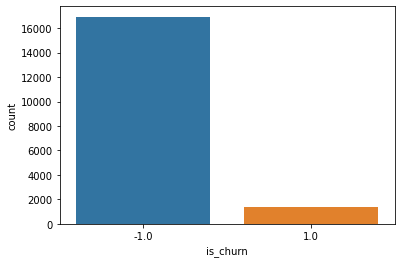

In [51]:
# Initial class distribution
sns.countplot(x=train_data['is_churn']);
train_data['is_churn'].value_counts()/train_data.shape[0]

The weights for the corresponding objects are set using the `sample_weight` parameter, which takes an array of weights.

Since we are using the `Pipeline` module, according to the documentation it is necessary to use` step_name__sample_weight`, which in our case is `model__sample_weight`. Depending on which approach is used (Cross-validation or `GridSearchCV`), you need to pass parameters in different ways.

**Cross-validation**

It is necessary to pass the following dictionary: `{'model__sample_weight': weights_array}` to the `fit_params` parameter.

In [52]:
# Define the following function for keeping track of weight values and the CV result 
def show_model_cvs_class_weights(model, x_train, y_train, cv_type, metrics, weights=np.linspace(0.05, 0.95, 20)):
    res_df = pd.DataFrame()
    
    for weight in log_progress(weights):
        cv_results = cross_validate(model,
                                    X=x_train,
                                    y=y_train, 
                                    cv=cv_type,
                                    scoring=metrics,
                                    error_score='raise',
                                    n_jobs=-1,
                                    fit_params={'model__sample_weight': y_train.apply(lambda x: weight if x == 1.0 else 1 - weight)})
           
        cv_results['Min_Class_Weight'] = weight 
        res_df = res_df.append(pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T)
    
    return res_df

In [53]:
%%time

# Cross-validate on the set of weights 
weights_cv_results = show_model_cvs_class_weights(
    model=model_pipeline,
    x_train=x_train,
    y_train=y_train,
    cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
    metrics=['precision', 'recall', 'f1', 'roc_auc'],
    weights=np.linspace(0.05, 0.95, 20)
)

weights_cv_results = weights_cv_results.reset_index(drop=True)


Wall time: 1min 28s


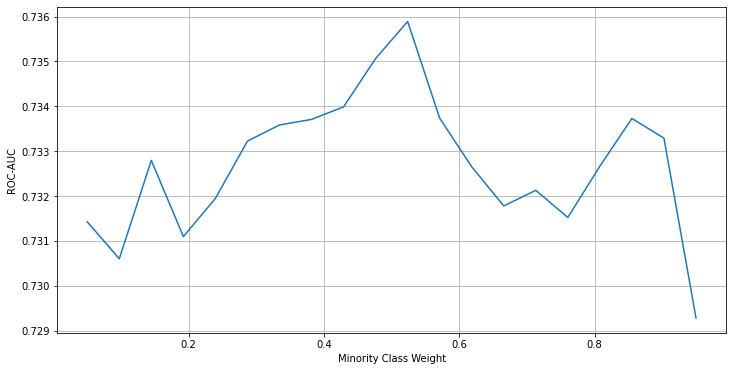

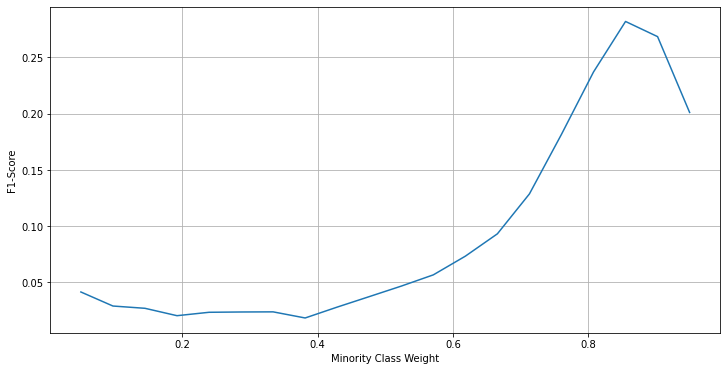

In [54]:
# ROC-AUC changing 
plt.figure(figsize=(12,6))
plt.plot(weights_cv_results['Min_Class_Weight'], weights_cv_results['test_roc_auc'])
plt.xlabel('Minority Class Weight')
plt.ylabel('ROC-AUC')
plt.grid();

# F1-Score changing 
plt.figure(figsize=(12,6))
plt.plot(weights_cv_results['Min_Class_Weight'], weights_cv_results['test_f1'])
plt.xlabel('Minority Class Weight')
plt.ylabel('F1-Score')
plt.grid();

In [55]:
weights_cv_results

,test_precision,test_recall,test_f1,test_roc_auc,Min_Class_Weight
0,0.197893,0.023238,0.041497,0.731424,0.050000
1,0.164509,0.015984,0.029014,0.730602,0.097368
2,0.196024,0.014530,0.026990,0.732795,0.144737
3,0.173529,0.010896,0.020422,0.731095,0.192105
4,0.238651,0.012348,0.023445,0.731948,0.239474
5,0.344643,0.012345,0.023713,0.733224,0.286842
6,0.350000,0.012348,0.023826,0.733584,0.334211
7,0.395556,0.009444,0.018390,0.733708,0.381579
8,0.459481,0.014530,0.028059,0.733988,0.428947
9,0.419561,0.019615,0.037366,0.735065,0.476316


It can be seen that we have a maximum of `ROC-AUC` at 10 iterations, but` F1-Score` is small. At iteration 17, everything is much better, but the `ROC-AUC` is slightly smaller. We choose iteration 17, which provides a good balance between `precision` and` recall`.

Another set of weights can be chosen, everything depends on our goals, for example, if we want to find users prone to churn as much as possible, then we can choose iteration 19, however, the `precision` is very small, therefore we will falsely define good customers as bad (extra costs) ...

Next, let's do a series of experiments with ***under/oversampling* methods**, determine the best one and re-plot the learning curves to see if we really did better.

### Undersampling
Let's implement the following methods:
- Random Undersampling
- One-Sided Selection
- Under-Sampling with Cluster Centroids
- Nearmiss 1 & 2 & 3

### Random Undersampling
The random oversampling/undersampling procedure can be performed using:
- Module `imblearn`
- On its own using the `pd.sample` method

The number of elements of the majority class `K` that need to be removed (in our case, we will simply collect a new random sample from objects of the majority class using the` pd.sample` method) will be selected for cross-validation.

Let's take a look at the position of objects in space again.

Number of Samples (Negative Class):  16921
Number of Samples (Positive Class):  1377


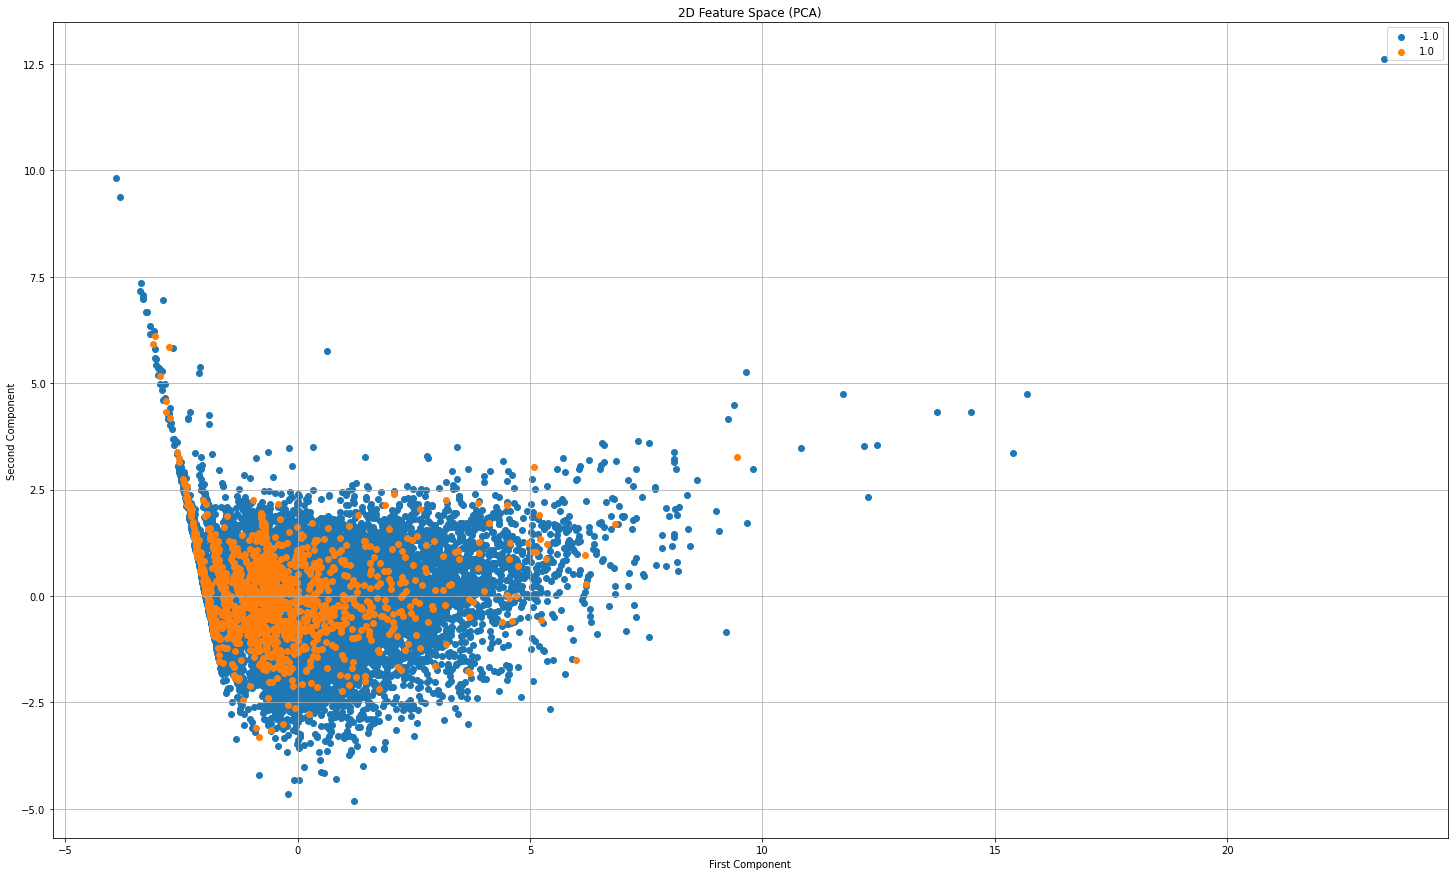

In [69]:
plot_multidim_data(x_train=x_train,
                   y_train=y_train, 
                   cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                   cat_bin_encoder=TargetEncoder(),
                   num_imputer=SimpleImputer(strategy='mean'),
                   num_scaler=StandardScaler(),
                   dim_red_method=PCA(n_components=2, random_state=SEED),
                   fig_size=(25,15), 
                   title='2D Feature Space (PCA)')

Classes are very **strongly mixed with each other**, there are also outliers for clients who are prone and not prone to churn.

This picture can give a good idea of which *under/oversamplig* methods can be used and which ones cannot ... because it all depends on the data, and some methods can only make worse.

Next, we define a function for *over/undersampling*, since we use *undersampling* then we will randomly collect objects from the majority class of different sizes and train the model. Let's determine the number of objects of the majority class on which the best quality is ensured.

In [58]:
# Function for over/under sampling 
def show_model_cvs_random_sampling(model, x_train, y_train, cv_type, metrics,
                                   sample_iters=20, sampling_type='under',
                                   target_labels=[-1, 1], random_state=SEED):
    res_df = pd.DataFrame()
    
    # Определяем число объектов мажоритарного и минорного классов
    # Define the number of objects for majority and minority class
    maj_class_size, min_class_size = y_train.value_counts()
    
    # Split the interval according to sample_iters parameter
    n_samples = np.linspace(min_class_size, maj_class_size, sample_iters)
    n_samples = np.floor(n_samples).astype('int') # Получим целочисленные значения
    
    # Split samples on classes 
    x_train[y_train.name] = y_train
    
    x_train_pos_class = x_train[x_train[y_train.name] == max(target_labels)] 
    x_train_neg_class = x_train[x_train[y_train.name] == min(target_labels)]
    
    x_train.drop(y_train.name, axis=1, inplace=True) # Чтобы после завершения, таргет не присутствовал в обучении
    
    if sampling_type == 'under':
        for sample_size in log_progress(n_samples):
            
            # Sample necessary number of elements for majority class 
            x_train_neg_under = x_train_neg_class.sample(sample_size, random_state=random_state)

            # Create Training Data
            x_train_under = pd.concat([x_train_neg_under, x_train_pos_class], axis=0)
            y_train = x_train_under[y_train.name]

            # Drop the target from training
            x_train_under.drop(y_train.name, axis=1, inplace=True)

            # Cross-validate
            cv_results = cross_validate(model, X=x_train_under, y=y_train, 
                                        cv=cv_type, scoring=metrics, error_score='raise', n_jobs=-1)

            cv_results['Sample_Size'] = sample_size
            res_df = res_df.append(pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T)
            
        return res_df
    
    else:
        for sample_size in log_progress(n_samples):
            
            # Sample necessary number of elements for minority class 
            x_train_pos_over = x_train_pos_class.sample(sample_size, replace=True, random_state=random_state)
            
            # Create Training Data
            x_train_over = pd.concat([x_train_neg_class, x_train_pos_over], axis=0)
            y_train = x_train_over[y_train.name]
        
            # Drop the target from training
            x_train_over.drop(y_train.name, axis=1, inplace=True)
        
            # Cross-validate
            cv_results = cross_validate(model, X=x_train_over, y=y_train, 
                                        cv=cv_type, scoring=metrics, error_score='raise', n_jobs=-1)
        
            cv_results['Sample_Size'] = sample_size
            res_df = res_df.append(pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T)
            
        return res_df

In [59]:
%%time 

# Define the best class ration  
under_cv_results = show_model_cvs_random_sampling(model=model_pipeline,
                                                  x_train=x_train,
                                                  y_train=y_train,
                                                  cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                                  metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                                  sampling_type='under',
                                                  sample_iters=20)

under_cv_results = under_cv_results.reset_index(drop=True)


Wall time: 53.5 s


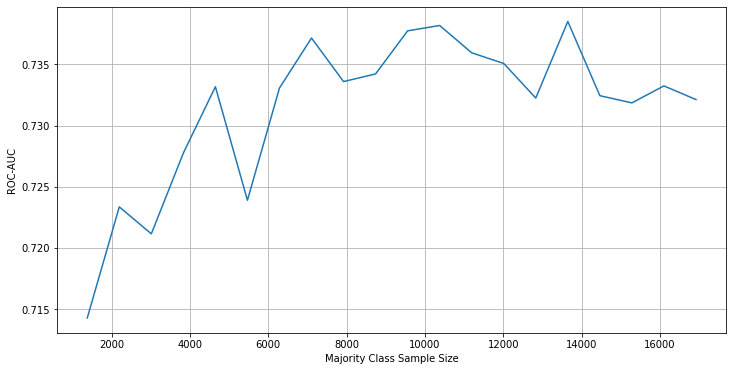

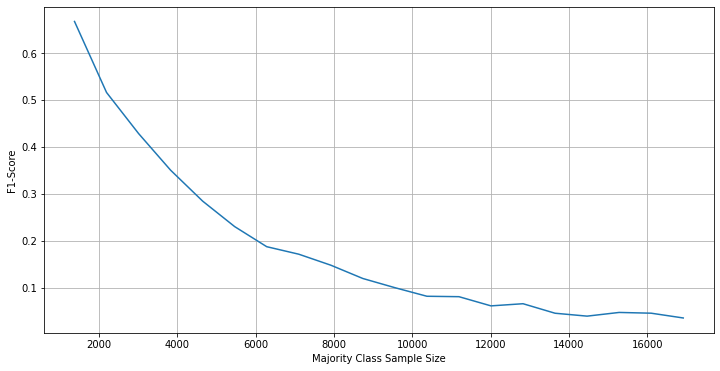

In [60]:
# ROC-AUC changing 
plt.figure(figsize=(12,6))
plt.plot(under_cv_results['Sample_Size'], under_cv_results['test_roc_auc'])
plt.xlabel('Majority Class Sample Size')
plt.ylabel('ROC-AUC')
plt.grid();

# F1-Score changing 
plt.figure(figsize=(12,6))
plt.plot(under_cv_results['Sample_Size'], under_cv_results['test_f1'])
plt.xlabel('Majority Class Sample Size')
plt.ylabel('F1-Score')
plt.grid();

In [61]:
under_cv_results

,test_precision,test_recall,test_f1,test_roc_auc,Sample_Size
0,0.656735,0.678986,0.667310,0.714262,1377.0
1,0.637386,0.434237,0.515884,0.723348,2195.0
2,0.639060,0.322422,0.428320,0.721142,3013.0
3,0.622485,0.244016,0.350144,0.727748,3831.0
4,0.608576,0.185897,0.284221,0.733171,4649.0
5,0.594211,0.143078,0.229853,0.723890,5467.0
6,0.579508,0.111834,0.187035,0.733062,6285.0
7,0.567574,0.100946,0.171042,0.737154,7103.0
8,0.577287,0.084967,0.147614,0.733594,7921.0
9,0.515991,0.067563,0.119234,0.734217,8739.0


The maximum `ROC-AUC` reaches at 10 iterations, however,` F1-Score` is very small, it is better to choose the 4th iteration, where `F1-Score` is better.

### One-Sided Selection
This method combines methods such as `Tomek Links` and` Condensed Neighbor (CNN) `.
- CNN removes big clumps of majority class
- Tomek Links "removes noise" and makes the class boundary more separable

In [70]:
from imblearn.pipeline import Pipeline # pipeline from imblearn must be used 
from imblearn.under_sampling import OneSidedSelection

# Redefine Pipeline 
model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes('object').columns.to_list(),
                           num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

# Add new stage downsampling
model_pipeline.steps.insert(1, ('downsampling', OneSidedSelection(sampling_strategy='majority', n_jobs=-1)))

The method has a number of hyperparameters, we will iterate over some of them

In [71]:
%%time

# Hyperparameters 
n_neighbors = [3, 6, 9, 12]
n_seeds_S = [1, 3, 5, 7]

# CV-results 
res_df = pd.DataFrame()

for neighbors in log_progress(n_neighbors):
    for seeds in log_progress(n_seeds_S):
        model_pipeline.steps[1] = ('downsampling', OneSidedSelection(sampling_strategy='majority',
                                                                     n_neighbors=neighbors,
                                                                     n_seeds_S=seeds, random_state=SEED, n_jobs=-1))
        
        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                                    cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                    scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)
        
        current_cv = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
        current_cv['n_neighbors'] = neighbors
        current_cv['n_seeds_S'] = seeds
        
        res_df = res_df.append(current_cv)
        
res_df = res_df.reset_index(drop=True)
res_df



Wall time: 3min 7s


,test_precision,test_recall,test_f1,test_roc_auc,n_neighbors,n_seeds_S
0,0.419235,0.02614,0.048990,0.733217,3,1
1,0.410902,0.02614,0.048975,0.733216,3,3
2,0.410902,0.02614,0.048975,0.733189,3,5
3,0.419235,0.02614,0.048990,0.733243,3,7
4,0.419235,0.02614,0.048990,0.733217,6,1
5,0.410902,0.02614,0.048975,0.733216,6,3
6,0.410902,0.02614,0.048975,0.733189,6,5
7,0.419235,0.02614,0.048990,0.733243,6,7
8,0.419235,0.02614,0.048990,0.733217,9,1
9,0.410902,0.02614,0.048975,0.733216,9,3


We can choose the second iteration with a combination of the parameters `n_neighbors = 3` and` n_seeds_S = 3`. `F1_Score` is very bad everywhere. This method is not suitable.

### Under-Sampling with Cluster Centroids

In [72]:
%%time
from imblearn.under_sampling import ClusterCentroids

model_pipeline.steps[1] = ('downsampling', ClusterCentroids(sampling_strategy='majority', random_state=SEED, 
                                                            n_jobs=-1, voting='hard'))

cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                            cv=StratifiedKFold(shuffle=True, random_state=SEED),
                            scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)

pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T

Wall time: 1min 10s


,test_precision,test_recall,test_f1,test_roc_auc
0,0.109027,0.782166,0.191376,0.681256


The quality has dropped, although the `recall` is not bad, the` F1-Score` is very small. The method is clearly not suitable.

### Nearmiss 1 & 2 & 3
There are several variants of this method, let's sort them all with different parameters.

We also pass in the `sampling_strategy` parameter a dictionary with the number of objects for the majority class. We have already defined this value using `Random Undersampling`

In [73]:
%%time

from imblearn.under_sampling import NearMiss

# Hyperparameters
versions = [1, 2, 3]
neighbours = [3, 6, 9]

# CV-results
near_miss_cv_df = pd.DataFrame()

for version in versions:
    for neighbour in neighbours:
        model_pipeline.steps[1] = ('downsampling', NearMiss(sampling_strategy={-1.0: 4649}, version=version,
                                                            n_neighbors=neighbour, n_jobs=-1))
        
        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                                    cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                    scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)
        
        cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
        cv_results['version'] = version
        cv_results['n_neighbors'] = neighbour
        
        near_miss_cv_df = near_miss_cv_df.append(cv_results)
        
near_miss_cv_df = near_miss_cv_df.reset_index(drop=True)
near_miss_cv_df

Wall time: 32.4 s


,test_precision,test_recall,test_f1,test_roc_auc,version,n_neighbors
0,0.063287,0.383441,0.108632,0.474846,1,3
1,0.061795,0.392885,0.106785,0.470440,1,6
2,0.062659,0.406688,0.108585,0.469072,1,9
3,0.084313,0.587439,0.147449,0.571414,2,3
4,0.079898,0.583850,0.140557,0.562549,2,6
5,0.085168,0.596951,0.149059,0.567139,2,9
6,0.190093,0.087874,0.119906,0.646985,3,3
7,0.189651,0.087874,0.119828,0.647176,3,6
8,0.189768,0.087874,0.119854,0.646971,3,9


The quality has also dropped and the `F1-Score` is small, we exclude this method from consideration.

### Oversampling
Now let's apply *oversampling*

We use the following methods:
- Random Oversampling
- SMOTE (Synthetic Minority Oversampling Technique) (likely to be bad)
- ADASYN (Adaptive Synthetic Sampling Approach)
- Combination SMOTE + Tomek Links

### Random Oversampling
We will randomly select objects of the minor class and increase the sample.

In [74]:
%%time 

over_cv_results = show_model_cvs_random_sampling(model=model_pipeline,
                                                 x_train=x_train,
                                                 y_train=y_train,
                                                 cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                                 metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                                 sampling_type='over',
                                                 sample_iters=20)

over_cv_results = over_cv_results.reset_index(drop=True)


Wall time: 3min 55s


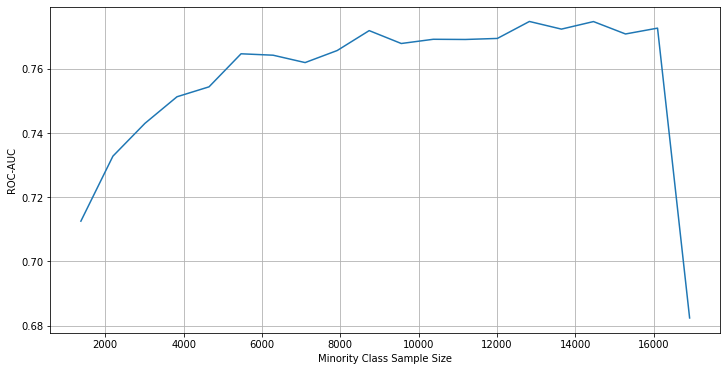

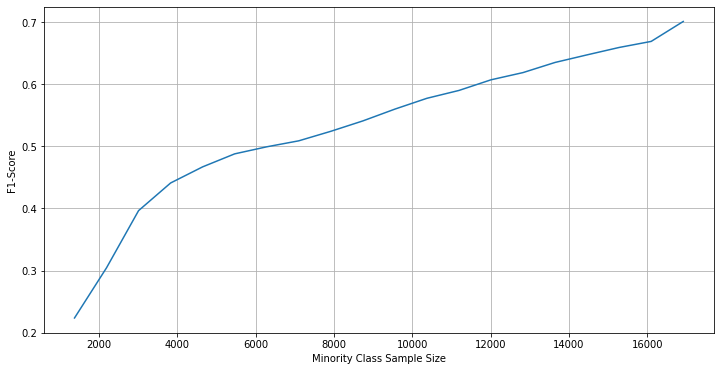

In [75]:
# ROC-AUC changing 
plt.figure(figsize=(12,6))
plt.plot(over_cv_results['Sample_Size'], over_cv_results['test_roc_auc'])
plt.xlabel('Minority Class Sample Size')
plt.ylabel('ROC-AUC')
plt.grid();

# F1-Score changing 
plt.figure(figsize=(12,6))
plt.plot(over_cv_results['Sample_Size'], over_cv_results['test_f1'])
plt.xlabel('Minority Class Sample Size')
plt.ylabel('F1-Score')
plt.grid();

In [76]:
over_cv_results

,test_precision,test_recall,test_f1,test_roc_auc,Sample_Size
0,0.228633,0.219318,0.223500,0.712521,1377.0
1,0.294508,0.316629,0.304406,0.732775,2195.0
2,0.324718,0.509457,0.396492,0.743000,3013.0
3,0.328787,0.670583,0.441043,0.751282,3831.0
4,0.327952,0.811147,0.467025,0.754375,4649.0
5,0.335153,0.897204,0.487967,0.764674,5467.0
6,0.338045,0.955131,0.499317,0.764232,6285.0
7,0.344823,0.971422,0.508964,0.761935,7103.0
8,0.357263,0.984723,0.524291,0.765684,7921.0
9,0.371884,0.992448,0.541027,0.771895,8739.0


The target metric has grown noticeably, as has the `F1-Score`. Best iteration 14. However, do not rejoice, we duplicated the data, which most likely led to overfitting, on the test the results most likely will not be so impressive.

### SMOTE
This algorithm generates new objects of the minor class that would be as similar as possible to the objects of the minor class, but slightly different.

The disadvantage of this approach is the fact that the algorithm blindly increases the density with examples in the area of a poorly represented class and, therefore, mixes the classes even more.

In the `sampling_strategy` parameter, we will pass a dictionary with the found ratio of classes that provide the maximum quality. This method has a hyperparameter `k_neighbors` which we select using cross-validation.

In [77]:
%%time
from imblearn.over_sampling import SMOTE

neighbours = [3, 6, 9]

smote_cv_res = pd.DataFrame()

for neighbour in log_progress(neighbours):
    model_pipeline.steps[1] = ('oversampling', SMOTE(sampling_strategy='minority',
                                                     k_neighbors=neighbour, random_state=SEED, n_jobs=-1))
    
    cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T 
    cv_results['k_neighbors'] = neighbour
    
    smote_cv_res = smote_cv_res.append(cv_results)

smote_cv_res = smote_cv_res.reset_index(drop=True)
smote_cv_res


Wall time: 35.1 s


,test_precision,test_recall,test_f1,test_roc_auc,k_neighbors
0,0.317062,0.082793,0.129583,0.704506,3
1,0.302295,0.075526,0.119421,0.709638,6
2,0.292244,0.072614,0.114392,0.709145,9


Quality has dropped, which is not surprising. Our classes are heavily mixed, and the algorithm just sampled the outliers even more. Let's have a look at the location of objects.

Number of Samples (Negative Class):  16921
Number of Samples (Positive Class):  16921
Wall time: 382 ms


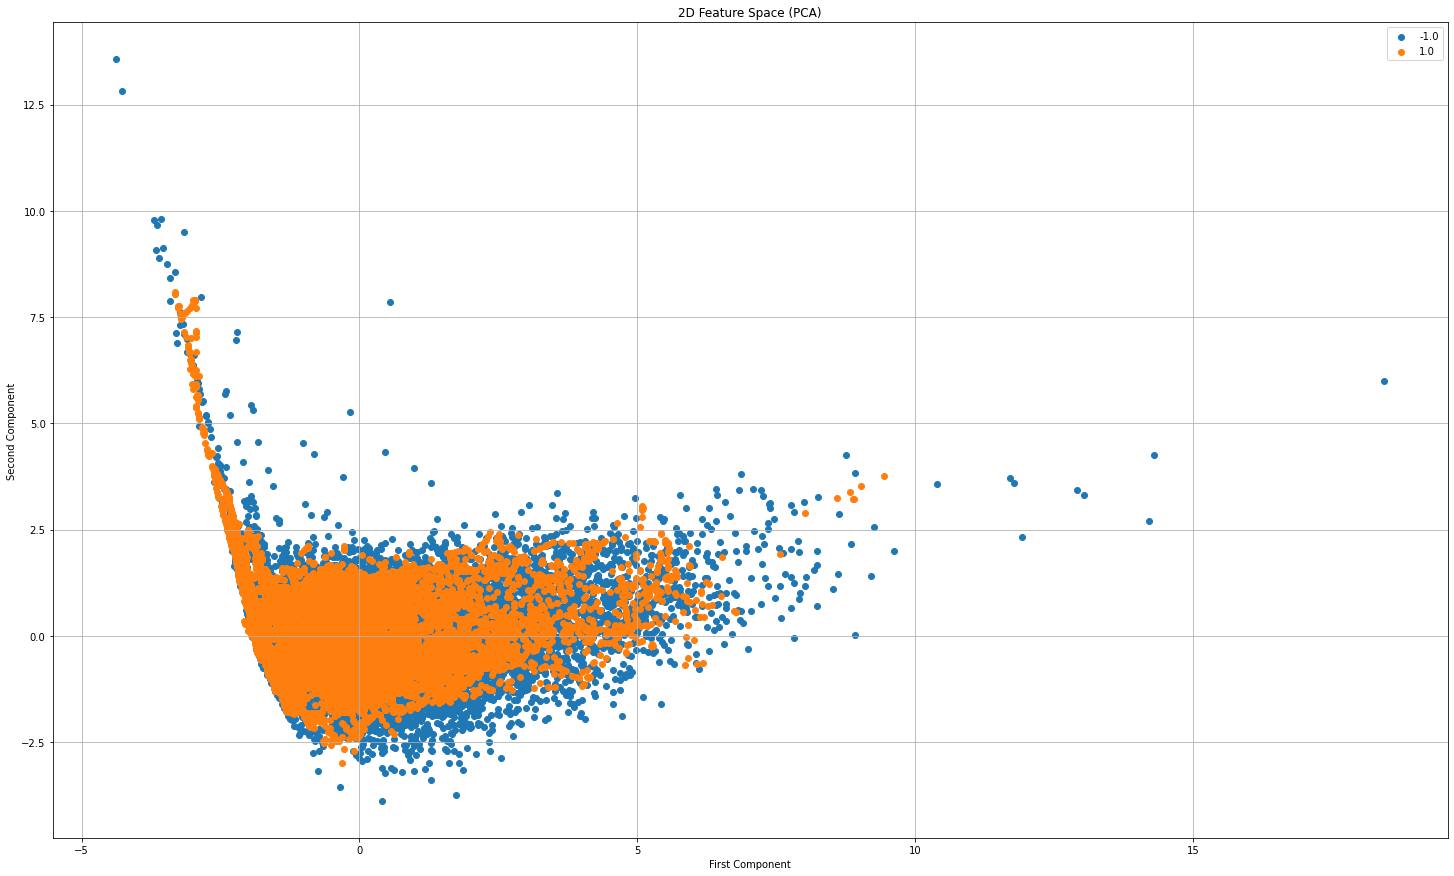

In [79]:
%%time

plot_multidim_data(x_train=x_train,
                   y_train=y_train, 
                   cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                   cat_bin_encoder=TargetEncoder(),
                   num_imputer=SimpleImputer(strategy='mean'),
                   num_scaler=StandardScaler(),
                   dim_red_method=PCA(n_components=2, random_state=SEED),
                   sampling_method=SMOTE(sampling_strategy='minority', k_neighbors=6, random_state=SEED, n_jobs=-1),
                   fig_size=(25,15), 
                   title='2D Feature Space (PCA)')

You can see how the density of the minor class has increased, the number of outliers have also increased.
### ADASYN

In [80]:
%%time

from imblearn.over_sampling import ADASYN

# Hyperparameters
neighbours = [3, 6, 9]

# Cv-results 
adasyn_cv_res = pd.DataFrame()

for neighbour in neighbours:
    model_pipeline.steps[1] = ('oversampling', ADASYN(sampling_strategy={-1.0: 16921, 1.0: 14466},
                                                      n_neighbors=neighbour, random_state=SEED, n_jobs=-1))
    
    cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                                cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)
    
    cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:, 2:].mean()).T 
    cv_results['n_neighbors'] = neighbour
    
    adasyn_cv_res = adasyn_cv_res.append(cv_results)
    
adasyn_cv_res = adasyn_cv_res.reset_index(drop=True)
adasyn_cv_res

Wall time: 2min 11s


,test_precision,test_recall,test_f1,test_roc_auc,n_neighbors
0,0.369108,0.063903,0.105784,0.697470,3
1,0.367412,0.065362,0.108845,0.704734,6
2,0.361179,0.063188,0.103334,0.699339,9


Almost the same results 

### SVMSMOTE

In [81]:
%%time

from imblearn.over_sampling import SVMSMOTE

# Hyperparameters
k_neighbors  = [3, 6, 9]
m_neighbors  = [5, 10, 15]

# CV-results 
smotesvm_cv_res = pd.DataFrame()

for k_neighbour in log_progress(k_neighbors):
    for m_neighbor in log_progress(m_neighbors):
        model_pipeline.steps[1] = ('oversampling', SVMSMOTE(sampling_strategy={-1.0: 16921, 1.0: 14466},
                                                            k_neighbors=k_neighbour, m_neighbors=m_neighbor, 
                                                            random_state=SEED, n_jobs=-1))

        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, 
                                    cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                    scoring=['precision', 'recall', 'f1', 'roc_auc'], error_score='raise', n_jobs=-1)

        cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T 
        cv_results['k_neighbors'] = k_neighbour
        cv_results['m_neighbors'] = m_neighbor

        smotesvm_cv_res = smotesvm_cv_res.append(cv_results)

smotesvm_cv_res = smotesvm_cv_res.reset_index(drop=True)
smotesvm_cv_res



Wall time: 6min 10s


,test_precision,test_recall,test_f1,test_roc_auc,k_neighbors,m_neighbors
0,0.265080,0.157584,0.196588,0.712687,3,5
1,0.275025,0.085700,0.127711,0.704202,3,10
2,0.295271,0.087144,0.132059,0.710674,3,15
3,0.257466,0.155402,0.192460,0.716617,6,5
4,0.273425,0.082050,0.123328,0.708816,6,10
5,0.325170,0.076986,0.120743,0.710114,6,15
6,0.260171,0.149589,0.188373,0.715999,9,5
7,0.289573,0.074798,0.115383,0.708003,9,10
8,0.307663,0.071892,0.114206,0.709722,9,15


### Under/Oversampling Methods Conclusion
These methods could not radically improve the situation. We choose three methods that have shown good results:
- Assigning weights to observations (`F1-Score: 0.282003`,` ROC-AUC: .733730`)
- Random Oversampling (`F1-Score: 0.647494`,` ROC-AUC: 0.774711`)
- Random Undersampling (`F1-Score: 0.284221`,` ROC-AUC: 0.733171`)

We can use any of them, but for now we select *Setting weights for observation*

Now let's check how the learning curves have changed after feature selection and determination of a method to deal with an imbalanced data.

In [85]:
# Pass dictionary with found weights 
min_class_weight = 0.855263
fit_params = {'model__sample_weight': y_train.apply(lambda x: min_class_weight if x == 1.0 else 1 - min_class_weight)}

model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes('object').columns.to_list(),
                           num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

Wall time: 39.3 s


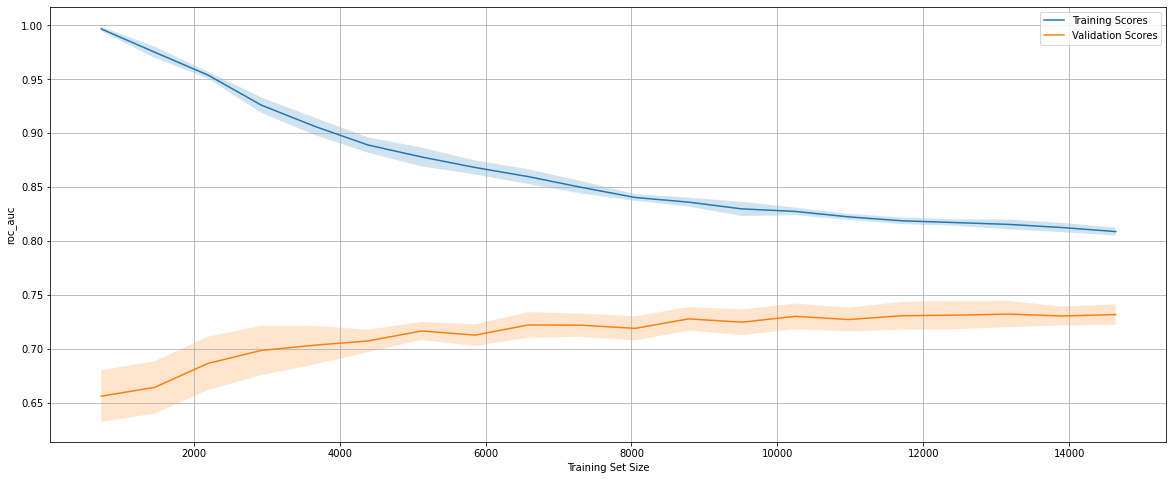

In [86]:
%%time
plot_learning_curve(model=model_pipeline,
                    x_train=x_train,
                    y_train=y_train, 
                    cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                    scorer='roc_auc', fit_params=fit_params)

**The divergance has decreased.** Feature selection has worked, we are moving in the right direction. Next, let's move on to the future processing part 

### Determining the Best Imputer for Features 

Let's find out which methods of filling in the missing values for features provide the best quality. To do this, we carry out a simple iteration over candidates

In [87]:
%%time

# Categorical Imputers 
cat_bin_imputers = [
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value='unknown')
]

# numeric Imputers  
num_imputers = [
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='constant', fill_value=-1e9),
    KNNImputer()
]

# CV-results
imputers_cv_res = pd.DataFrame()

for cat_bin_imputer in log_progress(cat_bin_imputers):
    for num_imputer in log_progress(num_imputers):
        model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes(['object']).columns.to_list(),
                                   num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                                   model=GradientBoostingClassifier(random_state=SEED),
                                   cat_bin_imputer=cat_bin_imputer,
                                   cat_bin_encoder=TargetEncoder(),
                                   num_imputer=num_imputer,
                                   num_scaler=StandardScaler())
            
        cv_results = cross_validate(model_pipeline,
                                    X=x_train,
                                    y=y_train,
                                    cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                    scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                    fit_params=fit_params,
                                    error_score='raise',
                                    n_jobs=-1)

        cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T

        cv_results['cat_bin_imputer'] = cat_bin_imputer
        cv_results['num_imputer'] = num_imputer
            
        imputers_cv_res = imputers_cv_res.append(cv_results)
        
        
imputers_cv_res = imputers_cv_res.reset_index(drop=True)
imputers_cv_res



Wall time: 1min 43s


,test_precision,test_recall,test_f1,test_roc_auc,cat_bin_imputer,num_imputer
0,0.215854,0.258522,0.234970,0.714195,SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='median')
1,0.228633,0.306469,0.261686,0.722222,SimpleImputer(strategy='most_frequent'),SimpleImputer()
2,0.210850,0.208435,0.208607,0.670691,SimpleImputer(strategy='most_frequent'),"SimpleImputer(fill_value=-1000000000.0, strate..."
3,0.220136,0.280327,0.246117,0.717204,SimpleImputer(strategy='most_frequent'),KNNImputer()
4,0.238438,0.284685,0.259284,0.726390,"SimpleImputer(fill_value='unknown', strategy='...",SimpleImputer(strategy='median')
5,0.250982,0.331159,0.285326,0.733110,"SimpleImputer(fill_value='unknown', strategy='...",SimpleImputer()
6,0.228105,0.222229,0.224392,0.685132,"SimpleImputer(fill_value='unknown', strategy='...","SimpleImputer(fill_value=-1000000000.0, strate..."
7,0.244086,0.301381,0.269400,0.727475,"SimpleImputer(fill_value='unknown', strategy='...",KNNImputer()


Best to use:
- `SimpleImputer (strategy = 'constant', fill_value = 'unknown')` to handle omissions for categorical features
- `SimpleImputer (strategy = 'mean')` to handle gaps in numeric features

### Determining the Best Scaler and Encoder
Determine which methods of scaling numerical features and encoding categorical ones provide the best quality. We also define it by brute force.

In [88]:
%%time

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler()
]

cat_encoders = [
    TargetEncoder(),
    OneHotEncoder(sparse=True, handle_unknown='ignore'),
    CatBoostEncoder(random_state=SEED),
    LeaveOneOutEncoder(random_state=SEED)
]

# CV-results
scaler_encoder_df = pd.DataFrame()

for cat_encoder in log_progress(cat_encoders):
    for scaler in log_progress(scalers):
        model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes(['object']).columns.to_list(),
                                   num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                                   model=GradientBoostingClassifier(random_state=SEED),
                                   cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                                   cat_bin_encoder=cat_encoder,
                                   num_imputer=SimpleImputer(strategy='mean'),
                                   num_scaler=scaler)
        
        cv_results = cross_validate(model_pipeline,
                                    X=x_train,
                                    y=y_train,
                                    cv=StratifiedKFold(shuffle=True, random_state=SEED),
                                    scoring=['precision', 'recall', 'f1', 'roc_auc'],
                                    fit_params=fit_params,
                                    error_score='raise',
                                    n_jobs=-1)
    
        cv_results = pd.DataFrame(pd.DataFrame(cv_results).iloc[:,2:].mean()).T
        
        cv_results['cat_encoder'] = cat_encoder
        cv_results['scaler'] = scaler
        

        scaler_encoder_df = scaler_encoder_df.append(cv_results)
    
               
scaler_encoder_df = scaler_encoder_df.reset_index(drop=True)
scaler_encoder_df 



Wall time: 1min 4s


,test_precision,test_recall,test_f1,test_roc_auc,cat_encoder,scaler
0,0.250982,0.331159,0.285326,0.733110,TargetEncoder(),StandardScaler()
1,0.250773,0.330432,0.284942,0.732936,TargetEncoder(),MinMaxScaler()
2,0.250982,0.331159,0.285326,0.733068,TargetEncoder(),RobustScaler()
3,0.246523,0.321014,0.278717,0.731124,OneHotEncoder(handle_unknown='ignore'),StandardScaler()
4,0.247492,0.322469,0.279886,0.731996,OneHotEncoder(handle_unknown='ignore'),MinMaxScaler()
5,0.246523,0.321014,0.278717,0.731118,OneHotEncoder(handle_unknown='ignore'),RobustScaler()
6,0.156960,0.367407,0.212463,0.684329,CatBoostEncoder(random_state=23),StandardScaler()
7,0.159493,0.365953,0.214928,0.686315,CatBoostEncoder(random_state=23),MinMaxScaler()
8,0.156960,0.367407,0.212463,0.684324,CatBoostEncoder(random_state=23),RobustScaler()
9,0.230357,0.304303,0.262154,0.721352,LeaveOneOutEncoder(random_state=23),StandardScaler()


Best to use:
- `TargetEncoder ()` for encoding categorical features
- `StandardScaler ()` for scaling numeric features

In [91]:
# Итоговый Pipeline 
model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes(['object']).columns.to_list(),
                           num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(random_state=SEED),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

### Fitting Model Hyperparameters (HyperOpt)
The main experiments have been carried out, the only thing that remains is to find the best model hyperparameters. The following methods can be applied:
- `GridSearchCV`
- `RandomizedSearchCV`
- `HyperOpt`

Because `GradientBoostingClassifier` has a lot of parameters, it is not a good idea to use` GridSearchCV`. It takes much time.
It is better to choose `RandomizedSearchCV` or, for example, a Bayesian approach (parameters are chosen from the so-called good areas, taking into account what results were obtained by the previous combination of parameters)

In [90]:
from hyperopt import tpe, hp, fmin, space_eval, Trials
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [92]:
# Define ModelHyperparameters class (in this form it will be more convenient)
class ModelHyperparameters:
    
    def __init__(self, model, x, y, params_space, n_trials, cv_metric, cv_type, fit_params, opt_algo=tpe.suggest, seed=23):
        self.model = model
        self.x = x
        self.y = y
        self.params_space = params_space
        self.n_trials = n_trials
        self.cv_metric = cv_metric
        self.cv_type = cv_type
        self.fit_params = fit_params
        self.opt_algo = opt_algo
        self.seed = seed
        self.trials = Trials()
        
    def _objective(self, params):
        self.model.set_params(**params)
        
        cv_score = cross_validate(estimator=self.model,
                                  X=self.x,
                                  y=self.y,
                                  cv=self.cv_type,
                                  scoring=self.cv_metric,
                                  error_score='raise',
                                  fit_params=self.fit_params,
                                  n_jobs=-1)
        
        auc_score = pd.DataFrame(pd.DataFrame(cv_score).mean()).iloc[2:, :].T['test_score'][0]
                                                    
        return -auc_score
        
    def optimize(self):
        return fmin(fn=self._objective,
                    space=self.params_space,
                    algo=self.opt_algo,
                    max_evals=self.n_trials,
                    trials=self.trials,
                    rstate=np.random.RandomState(self.seed))

It turned out that **not all parameters should be selected**, since some parameters are very good by default and changing them leads to a decrease in quality. The following hyperparameter approximations were determined:

In [93]:
# Initial hyperparameters sapce
params_space = {
    'model__learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)),
    'model__n_estimators': ho_scope.int(hp.quniform('n_estimators', 50, 500, 1)),
    'model__criterion': hp.choice('criterion', ['friedman_mse', 'mse']), # don't use mae
    'model__min_samples_split': hp.loguniform('min_samples_split', np.log(0.1), np.log(1)),
    'model__max_depth':  ho_scope.int(hp.quniform('max_depth', 1, 8, 1)),
    'model__max_features': ho_scope.int(hp.quniform('max_features', 1, x_train.shape[1], 1)),
    'model__random_state': SEED
} 

In [94]:
# Define object model_hyperparameters
model_hyperparameters = ModelHyperparameters(model=model_pipeline, x=x_train, y=y_train,
                                             params_space=params_space, n_trials=50, cv_metric='roc_auc',
                                             fit_params=fit_params,
                                             cv_type=StratifiedKFold(shuffle=True, random_state=SEED))

# Define the best hyperparameters combination
best_params_hp = model_hyperparameters.optimize()
best_params_hp

100%|██████████| 50/50 [05:09<00:00,  6.18s/trial, best loss: -0.7364149941362905]


{'criterion': 1,
 'learning_rate': 0.034049411331746084,
 'max_depth': 5.0,
 'max_features': 10.0,
 'min_samples_split': 0.5593960786909217,
 'n_estimators': 328.0}

Optimization has only slightly improved the quality.

In [95]:
# Redefine model hyperparameters
hp_best_params = {
    'criterion': 'mse',
    'learning_rate': 0.034049411331746084,
    'max_depth': 5,
    'max_features': 10,
    'min_samples_split': 0.5593960786909217,
    'n_estimators': 328,
    'random_state': SEED
}

### Final Solution 
Now let's build the final solution based on our experiments. A lot of work has been done to determine the best preprocessing of features, their selection, solving the problem of class imbalance, and finally the selection of model hyperparameters.

Let's build the final solution and look again at the importance of the features.

In [99]:
# Final Pipeline
model_pipeline = make_pipe(cat_bin_columns=x_train.select_dtypes('object').columns.to_list(),
                           num_columns=x_train.select_dtypes(['int64', 'float64']).columns.to_list(),
                           model=GradientBoostingClassifier(**hp_best_params),
                           cat_bin_imputer=SimpleImputer(strategy='constant', fill_value='unknown'),
                           cat_bin_encoder=TargetEncoder(),
                           num_imputer=SimpleImputer(strategy='mean'),
                           num_scaler=StandardScaler())

model_pipeline.fit(x_train, y_train, 
                   model__sample_weight=y_train.apply(lambda x: min_class_weight if x == 1.0 else 1 - min_class_weight))

Pipeline(steps=[('feature_transformations',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_bin_transformations',
                                                  Pipeline(steps=[('cat_bin_imputing',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('cat_bin_encoding',
                                                                   TargetEncoder()),
                                                                  ('final_imputing',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['Var203', 'Var204', 'Var205',


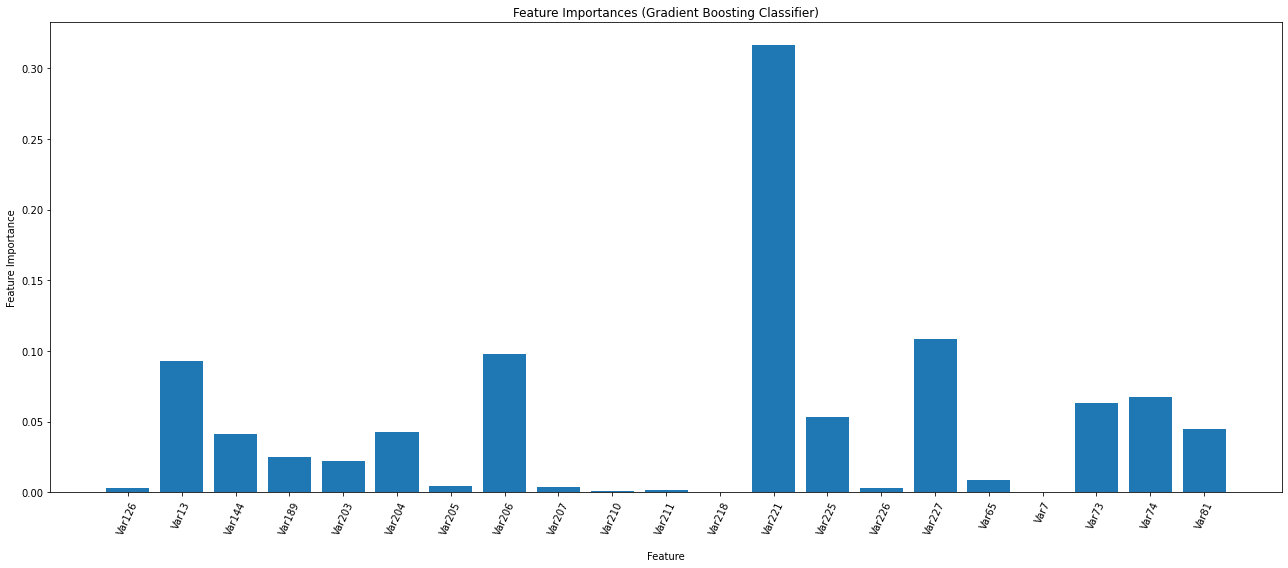

In [100]:
# Feature importances 
plt.figure(figsize=(18,8))
plt.bar(x_train.columns, model_pipeline.steps[1][1].feature_importances_)
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosting Classifier)')
plt.xticks(rotation=65)
plt.tight_layout();

Almost all the features that we have selected are somehow important for the model. Features: `Var221, Var206, Var227` are the top 3 most important (these are categorical features). There are also features that are almost unimportant for the model `Var218, Var210, Var7 ...`

If we compare the results with without feature selection, then we saw how most of the features were simply unimportant for the model, but here almost all features are important, albeit in different ways (some are more, others are less)

### Quality Improvement (Ideas)
More powerful models can be used:
- XGBoost
- LightGBM
- CatBoost

These models are very strong and most likely with the correct setting it will be possible to further improve the quality. Also, do not forget about categorical features, they can also be preprocessed, for example, by combining rare categories.

### Kaggle Score
It is interesting to see what actually `roc_auc` we have on the test set on Kaggle

In [101]:
# Test data
test_data = pd.read_csv('orange_small_churn_test_data.csv')

columns_to_use = x_train.columns.to_list()
test_data = test_data[columns_to_use]

# Function for submission
def to_submission(data, f_name):
    result = pd.DataFrame({'Id':range(data[:,1].shape[0]),
                           'result':data[:,1]})
    result.to_csv(f_name, index=False)

In [102]:
# Predict
preds = model_pipeline.predict_proba(test_data)
to_submission(preds, 'gb_from_project.csv')

The test score `0.71287`